Descompresion de datos

In [33]:
import missingno as msno
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from unidecode import unidecode
from pandas.api.types import CategoricalDtype
import geopandas

In [34]:
def iqr(x):
    """Funci√≥n para calcular el Rango Intercuart√≠lico."""
    return x.quantile(0.75) - x.quantile(0.25)

def mode(x):
    """Funci√≥n para obtener la moda (el primer valor si hay m√∫ltiples)."""
    return x.mode().iloc[0] if not x.mode().empty else np.nan

def limpiar_texto(texto):
    if not isinstance(texto, str):
        return texto
    limpio = unidecode(texto)
    limpio = re.sub(r'[\s-]+', '_', limpio)
    limpio = re.sub(r'[^\w]', '', limpio)
    return limpio.lower()


In [35]:
df_bases = pd.read_fwf(
    'datos/estaciones_smn.txt', 
    skiprows=2, 
    header=None, 
    encoding='latin-1'
)

nombres_columnas = [
    'nombre_original', 'provincia', 'lat_gr', 'lat_min',
    'lon_gr', 'lon_min', 'altura', 'nro', 'oaci'
]

df_bases.columns = nombres_columnas

df_bases['nombre_original'] = df_bases['nombre_original'].str.strip()
df_bases['provincia'] = df_bases['provincia'].str.strip()

df_bases['latitud'] = df_bases['lat_gr'] + np.sign(df_bases['lat_gr']) * (df_bases['lat_min'] / 60)
df_bases['longitud'] = df_bases['lon_gr'] + np.sign(df_bases['lon_gr']) * (df_bases['lon_min'] / 60)

df_bases = df_bases.drop(columns=['lat_gr', 'lat_min', 'lon_gr', 'lon_min'])

df_bases.head()


nombre_original  provincia  altura      nro  oaci    latitud  \
0          BASE BELGRANO II  ANTARTIDA   256.0  89034.0  SAYB -77.866667   
1  BASE CARLINI (EX JUBANY)  ANTARTIDA    11.0  89053.0  SAYJ -62.233333   
2            BASE ESPERANZA  ANTARTIDA    24.0  88963.0  SAYE -63.383333   
3             BASE MARAMBIO  ANTARTIDA   198.0  89055.0  SAWB -64.233333   
4              BASE ORCADAS  ANTARTIDA    12.0  88968.0  SAYO -60.733333   

    longitud  
0 -34.616667  
1 -58.650000  
2 -56.983333  
3 -56.616667  
4 -44.733333

In [36]:
nombres_originales_df_bases=df_bases['nombre_original'].unique()

In [37]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

nombre_excel = "Estad√≠sticas normales Datos abiertos 1991-2020.xlsx"
ruta_completa = os.path.join('datos', nombre_excel)

if not os.path.exists(ruta_completa):
    print(f"Error: El archivo '{ruta_completa}' no se encontr√≥. Aseg√∫rate de que el archivo ZIP se descomprimi√≥ correctamente y el archivo .xlsx est√° en la carpeta 'datos'.")
else:
    try:
        # Cargar sin especificar header para ver el raw data y encontrar la fila correcta
        df = pd.read_excel(ruta_completa, header=None)
        header_row_index = -1
        for i in range(min(10, len(df))):
            row_as_str = df.iloc[i].astype(str).str.lower()
            if ('estaci√≥n' in row_as_str.values and 'valor medio de' in row_as_str.values):
                header_row_index = i
                break

        if header_row_index != -1:
            print(f"\n¬°Encabezado detectado en la fila (0-indexada): {header_row_index}!")
    except Exception as e:
        print(f"Ocurri√≥ un error al intentar la carga inicial para depuraci√≥n: {e}")
        

df = pd.read_excel(ruta_completa, header=header_row_index)
df_largo = df.melt(
    id_vars=['Estaci√≥n', 'Valor Medio de'],
    var_name='Mes',
    value_name='Valor'
)

# --- Limpieza de Nombres y Caracteres Especiales ---

# Renombrar las variables a un formato limpio (sin espacios ni s√≠mbolos)
mapa_nombres = {
    'Temperatura (¬∞C)': 'temperatura_c',
    'Temperatura m√°xima (¬∞C)': 'temperatura_maxima_c',
    'Temperatura m√≠nima (¬∞C)': 'temperatura_minima_c',
    'Humedad relativa (%)': 'humedad_relativa_porcentaje',
    'Velocidad del Viento (km/h) (2011-2020)': 'velocidad_viento_kmh',
    'Nubosidad total (octavos)': 'nubosidad_octavos',
    'Precipitaci√≥n (mm)': 'precipitacion_mm',
    'Frecuencia de d√≠as con Precipitaci√≥n superior a 1.0 mm': 'frecuencia_dias_precipitacion_gt_1mm'
}
estaciones_df_final=df_largo['Estaci√≥n'].unique()
df_largo['Variable'] = df_largo['Valor Medio de'].replace(mapa_nombres)
df_largo = df_largo.drop(columns=['Valor Medio de'])
df_largo['Estaci√≥n'] = df_largo['Estaci√≥n'].apply(limpiar_texto)
df_largo['Mes'] = df_largo['Mes'].apply(limpiar_texto)
df_bases['Estaci√≥n'] = df_bases['nombre_original'].apply(limpiar_texto)
df_bases = df_bases.drop(columns=['nombre_original'])
# Procesamiento de valores
df_largo['Valor'] = pd.to_numeric(df_largo['Valor'], errors='coerce')


# --- Creaci√≥n del DataFrame Final ---
columnas_ordenadas = ['Estaci√≥n', 'Variable', 'Mes', 'Valor']
df_final = df_largo[columnas_ordenadas].copy()


# Definir el orden correcto de los meses
meses_ordenados = [
    'ene', 'feb', 'mar', 'abr', 'may', 'jun',
    'jul', 'ago', 'sep', 'oct', 'nov', 'dic'
]

# Crear el tipo de dato Categ√≥rico con el orden definido
tipo_mes_categorico = CategoricalDtype(categories=meses_ordenados, ordered=True)

# Aplicar el nuevo tipo a la columna 'Mes'
df_final['Mes'] = df_final['Mes'].astype(tipo_mes_categorico)

correcciones_estaciones = {
    'coronel_pringles_aero': 'coronel_pringles_aero',
    'el_trebol': 'el_trebol',
    'presidencia_roque_saenz_pena_aero': 'presidencia_roque_saenz_pena_a', 
    'san_miguel': 'san_miguel',
}

df_final['Estaci√≥n'] = df_final['Estaci√≥n'].map(correcciones_estaciones).fillna(df_final['Estaci√≥n'])
df_enriquecido = pd.merge(
    left=df_final,
    right=df_bases, 
    on='Estaci√≥n',
    how='left'
)

mapa_regiones = {
    'jujuy': 'NOA',
    'salta': 'NOA',
    'formosa': 'NEA',
    'misiones': 'NEA',
    'tucuman': 'NOA',
    'santiago del es': 'NOA',
    'chaco': 'NEA',
    'corrientes': 'NEA',
    'catamarca': 'NOA',
    'la rioja': 'NOA',
    'cordoba': 'Pampeana',
    'santa fe': 'Pampeana',
    'san juan': 'Cuyo',
    'entre rios': 'NEA',
    'mendoza': 'Cuyo',
    'san luis': 'Cuyo',
    'la pampa': 'Pampeana',
    'buenos aires': 'Pampeana',
    'capital federal': 'Pampeana',
    'neuquen': 'Patagonia',
    'rio negro': 'Patagonia',
    'chubut': 'Patagonia',
    'santa cruz': 'Patagonia',
    'tierra del fueg': 'Patagonia', 
    'antartida': 'Ant√°rtida'
}
# Limpiamos la columna 'provincia' y creamos la columna 'region'
df_enriquecido['region'] = df_enriquecido['provincia'].str.lower().map(mapa_regiones)
df_enriquecido.to_csv('datos/dataframe_enriquecido.csv', index=False)


¬°Encabezado detectado en la fila (0-indexada): 4!


In [38]:
estaciones_final_limpias = set(df_final['Estaci√≥n'].unique())
estaciones_bases_limpias = set(df_bases['Estaci√≥n'].unique())

no_coinciden_en_final = sorted(list(estaciones_final_limpias - estaciones_bases_limpias))
no_coinciden_en_bases = sorted(list(estaciones_bases_limpias - estaciones_final_limpias))

print("\n---")
print("Estaciones en df_final (LIMPIAS) que NO se encuentran en df_bases (LIMPIAS):")
if no_coinciden_en_final:
    for nombre in no_coinciden_en_final:
        print(f"- {nombre}")
else:
    print("¬°Todos los nombres limpios de df_final['Estaci√≥n'] se encuentran en df_bases['Estaci√≥n']!")

print("\n---")
print("Estaciones en df_bases (LIMPIAS) que NO se encuentran en df_final (LIMPIAS):")
if no_coinciden_en_bases:
    for nombre in no_coinciden_en_bases:
        print(f"- {nombre}")
else:
    print("¬°Todos los nombres limpios de df_bases['Estaci√≥n'] se encuentran en df_final['Estaci√≥n']!")
print("---")


---
Estaciones en df_final (LIMPIAS) que NO se encuentran en df_bases (LIMPIAS):
- coronel_pringles_aero
- el_trebol
- san_miguel

---
Estaciones en df_bases (LIMPIAS) que NO se encuentran en df_final (LIMPIAS):
- benito_juarez
- campo_de_mayo_aero
- chapelco_aero
- chepes
- ero
- escuela_de_aviacion_militar_ae
- ituzaingo
- mariano_moreno_aero
- mercedes_aero_ctes
- merlo_aero
- metan
- moron_aero
- paso_de_indios
- puerto_madryn_aero
- rafaela_aero
- rivadavia
- ro
- santa_cruz_aero
- santa_rosa_de_conlara_aero
- sunchales_aero
- termas_de_rio_hondo_aero
- trenque_lauquen
- uspallata
- victorica
- villa_gesell_aero
---


| Variable      | Descripci√≥n                                                                 |
| :------------ | :-------------------------------------------------------------------------- |
| `Estaci√≥n`    | Nombre de la estaci√≥n meteorol√≥gica.                                        |
| `Variable`    | Tipo de variable clim√°tica medida (ej., temperatura, humedad).             |
| `Mes`         | Mes en que se registr√≥ el valor de la variable.                             |
| `Valor`       | Valor num√©rico de la variable medida.                                       |
| `provincia`   | Provincia donde se encuentra la estaci√≥n meteorol√≥gica.                     |
| `altura`      | Altitud de la estaci√≥n meteorol√≥gica en metros sobre el nivel del mar.      |
| `nrooac`      | N√∫mero o c√≥digo de identificaci√≥n de la estaci√≥n seg√∫n la OACI (Organizaci√≥n de Aviaci√≥n Civil Internacional) |
| `latitud`     | Latitud geogr√°fica de la estaci√≥n en grados decimales.                     |
| `longitud`    | Longitud geogr√°fica de la estaci√≥n en grados decimales.                    |
| `region`      | Regi√≥n geogr√°fica a la que pertenece la estaci√≥n.                           |

In [39]:
df_enriquecido.head()

Estaci√≥n                     Variable  Mes  Valor provincia  altura      nro  oaci  latitud  longitud region
0  la_quiaca_observatorio                temperatura_c  ene   13.2     JUJUY  3459.0  87007.0  SASQ    -22.1     -65.6    NOA
1  la_quiaca_observatorio         temperatura_maxima_c  ene   20.6     JUJUY  3459.0  87007.0  SASQ    -22.1     -65.6    NOA
2  la_quiaca_observatorio         temperatura_minima_c  ene    7.7     JUJUY  3459.0  87007.0  SASQ    -22.1     -65.6    NOA
3  la_quiaca_observatorio  humedad_relativa_porcentaje  ene   62.6     JUJUY  3459.0  87007.0  SASQ    -22.1     -65.6    NOA
4  la_quiaca_observatorio         velocidad_viento_kmh  ene    6.5     JUJUY  3459.0  87007.0  SASQ    -22.1     -65.6    NOA

In [40]:
df_enriquecido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Estaci√≥n   9408 non-null   object  
 1   Variable   9408 non-null   object  
 2   Mes        9408 non-null   category
 3   Valor      8555 non-null   float64 
 4   provincia  9120 non-null   object  
 5   altura     9120 non-null   float64 
 6   nro        9120 non-null   float64 
 7   oaci       9024 non-null   object  
 8   latitud    9120 non-null   float64 
 9   longitud   9120 non-null   float64 
 10  region     9120 non-null   object  
dtypes: category(1), float64(5), object(5)
memory usage: 744.7+ KB


# An√°lisis de Tipos de Datos y Discrepancias en el Conteo de Nulos

Hemos revisado la estructura de tu DataFrame y los tipos de datos asignados a cada columna. En general, los tipos de datos son apropiados para el tipo de informaci√≥n que contienen. Sin embargo, hay una clara diferencia en el n√∫mero de valores no nulos entre algunas columnas, lo cual es importante entender.

---

## An√°lisis de Tipos de Datos

Aqu√≠ te presento una tabla que resume cada columna, su tipo de dato, y si este tipo tiene sentido en el contexto de tus datos:

| Columna     | Tipo de Dato | ¬øTiene Sentido? | Explicaci√≥n                                                                                                                                      |
| :---------- | :----------- | :-------------- | :----------------------------------------------------------------------------------------------------------------------------------------------- |
| `Estaci√≥n`  | `object`     | S√≠              | Los nombres de las estaciones meteorol√≥gicas son cadenas de texto.                                                                               |
| `Variable`  | `object`     | S√≠              | Los tipos de variables clim√°ticas (temperatura, humedad, etc.) son cadenas de texto.                                                             |
| `Mes`       | `category`   | S√≠              | Los meses son un conjunto finito de valores repetitivos (enero, febrero, etc.), por lo que el tipo `category` es eficiente y adecuado.        |
| `Valor`     | `float64`    | S√≠              | Las mediciones clim√°ticas (temperaturas, porcentajes, velocidades) suelen ser n√∫meros con decimales. La presencia de **8555 valores no nulos** indica que hay datos faltantes para algunas mediciones. |
| `provincia` | `object`     | S√≠              | Los nombres de las provincias son cadenas de texto.                                                                                              |
| `altura`    | `float64`    | S√≠              | La altitud se representa como un n√∫mero con decimales.                                                                                         |
| `nro`       | `float64`    | S√≠              | Los n√∫meros de identificaci√≥n, aunque a menudo enteros, pueden ser `float64` si se introdujeron valores `NaN` durante el proceso de fusi√≥n, ya que las columnas de enteros no admiten `NaN` directamente. |
| `oaci`      | `object`     | S√≠              | Los c√≥digos OACI son generalmente cadenas alfanum√©ricas. La presencia de **9024 valores no nulos** sugiere que no todas las estaciones tienen un c√≥digo OACI registrado o que estaba ausente en el DataFrame de origen. |
| `latitud`   | `float64`    | S√≠              | La latitud es un n√∫mero con decimales.                                                                                                         |
| `longitud`  | `float64`   | S√≠              | La longitud es un n√∫mero con decimales.                                                                                                        |
| `region`    | `object`     | S√≠              | Los nombres de las regiones son cadenas de texto.                                                                                                |

---

## Explicaci√≥n de la Discrepancia en el Conteo de Nulos

Observamos una diferencia clave en el conteo de valores no nulos:
* Las columnas como **`Estaci√≥n`, `Variable`, `Mes` y `Valor` tienen 9408 entradas no nulas**.
* Las columnas como **`provincia`, `altura`, `nro`, `oaci`, `latitud`, `longitud` y `region` tienen 9120 entradas no nulas**.

Esta diferencia se debe a la **fusi√≥n de dos DataFrames (`df_final` y `df_bases`)**, donde no todas las estaciones estaban presentes en ambos.

Cuando realizaste la fusi√≥n, es probable que se haya usado un tipo de `merge` (como un `left merge` desde `df_final` o un `outer merge`) que mantuvo todas las filas de uno de los DataFrames o de ambos.

Analicemos la situaci√≥n con base en la informaci√≥n que proporcionaste:

* **Estaciones en `df_final` que NO se encuentran en `df_bases`:**
    * `coronel_pringles_aero`
    * `el_trebol`
    * `san_miguel`

    Para las filas correspondientes a estas 3 estaciones (presentes en `df_final`), las columnas de metadatos de la estaci√≥n (`provincia`, `altura`, `nro`, `oaci`, `latitud`, `longitud`, `region`) quedaron con valores **nulos** (`NaN`), ya que no se encontr√≥ informaci√≥n coincidente en `df_bases`. Estas estaciones contribuyen al total de 9408 registros de mediciones, pero no a los 9120 registros de metadatos completos.

In [41]:
df_enriquecido.isnull()

Estaci√≥n  Variable    Mes  Valor  provincia  altura    nro   oaci  latitud  longitud  region
0        False     False  False  False      False   False  False  False    False     False   False
1        False     False  False  False      False   False  False  False    False     False   False
2        False     False  False  False      False   False  False  False    False     False   False
3        False     False  False  False      False   False  False  False    False     False   False
4        False     False  False  False      False   False  False  False    False     False   False
...        ...       ...    ...    ...        ...     ...    ...    ...      ...       ...     ...
9403     False     False  False  False      False   False  False  False    False     False   False
9404     False     False  False   True      False   False  False  False    False     False   False
9405     False     False  False  False      False   False  False  False    False     False   False
9406     False     False  False   True      False   False  False  False    False     False   False
9407     False     False  False   True      False   False  False  False    False     False   False

[9408 rows x 11 columns]

In [42]:
df_enriquecido.isna()

Estaci√≥n  Variable    Mes  Valor  provincia  altura    nro   oaci  latitud  longitud  region
0        False     False  False  False      False   False  False  False    False     False   False
1        False     False  False  False      False   False  False  False    False     False   False
2        False     False  False  False      False   False  False  False    False     False   False
3        False     False  False  False      False   False  False  False    False     False   False
4        False     False  False  False      False   False  False  False    False     False   False
...        ...       ...    ...    ...        ...     ...    ...    ...      ...       ...     ...
9403     False     False  False  False      False   False  False  False    False     False   False
9404     False     False  False   True      False   False  False  False    False     False   False
9405     False     False  False  False      False   False  False  False    False     False   False
9406     False     False  False   True      False   False  False  False    False     False   False
9407     False     False  False   True      False   False  False  False    False     False   False

[9408 rows x 11 columns]

In [43]:
df_enriquecido.isnull().sum() 

Estaci√≥n       0
Variable       0
Mes            0
Valor        853
provincia    288
altura       288
nro          288
oaci         384
latitud      288
longitud     288
region       288
dtype: int64

In [44]:
df_enriquecido.isna().mean().round(4)*100

Estaci√≥n     0.00
Variable     0.00
Mes          0.00
Valor        9.07
provincia    3.06
altura       3.06
nro          3.06
oaci         4.08
latitud      3.06
longitud     3.06
region       3.06
dtype: float64

In [45]:
df_enriquecido.dtypes

Estaci√≥n       object
Variable       object
Mes          category
Valor         float64
provincia      object
altura        float64
nro           float64
oaci           object
latitud       float64
longitud      float64
region         object
dtype: object

In [46]:
df_enriquecido['Mes'].unique()

['ene', 'feb', 'mar', 'abr', 'may', ..., 'ago', 'sep', 'oct', 'nov', 'dic']
Length: 12
Categories (12, object): ['ene' < 'feb' < 'mar' < 'abr' ... 'sep' < 'oct' < 'nov' < 'dic']

In [47]:
df_enriquecido['Variable'].unique()

array(['temperatura_c', 'temperatura_maxima_c', 'temperatura_minima_c',
       'humedad_relativa_porcentaje', 'velocidad_viento_kmh',
       'nubosidad_octavos', 'precipitacion_mm',
       'frecuencia_dias_precipitacion_gt_1mm'], dtype=object)

In [48]:
df_enriquecido['Estaci√≥n'].unique()

array(['la_quiaca_observatorio', 'oran_aero', 'tartagal_aero',
       'jujuy_aero', 'jujuy_u_n', 'salta_aero', 'las_lomitas',
       'iguazu_aero', 'tucuman_aero', 'santiago_del_estero_aero',
       'presidencia_roque_saenz_pena_a', 'resistencia_aero',
       'formosa_aero', 'bernardo_de_irigoyen_aero', 'corrientes_aero',
       'posadas_aero', 'obera', 'tinogasta', 'chilecito_aero',
       'la_rioja_aero', 'catamarca_aero', 'villa_de_maria_del_rio_seco',
       'ceres_aero', 'reconquista_aero', 'paso_de_los_libres_aero',
       'jachal', 'san_juan_aero', 'chamical_aero', 'villa_dolores_aero',
       'cordoba_aero', 'cordoba_observatorio', 'pilar_observatorio',
       'sauce_viejo_aero', 'parana_aero', 'monte_caseros_aero',
       'concordia_aero', 'san_martin_mza', 'mendoza_aero',
       'mendoza_observatorio', 'san_luis_aero', 'villa_reynolds_aero',
       'rio_cuarto_aero', 'marcos_juarez_aero', 'venado_tuerto_aero',
       'el_trebol', 'rosario_aero', 'gualeguaychu_aero', 'malargue

In [49]:
df_enriquecido['provincia'].unique()

array(['JUJUY', 'SALTA', 'FORMOSA', 'MISIONES', 'TUCUMAN',
       'SANTIAGO DEL ES', 'CHACO', 'CORRIENTES', 'CATAMARCA', 'LA RIOJA',
       'CORDOBA', 'SANTA FE', 'SAN JUAN', 'ENTRE RIOS', 'MENDOZA',
       'SAN LUIS', nan, 'LA PAMPA', 'BUENOS AIRES', 'CAPITAL FEDERAL',
       'NEUQUEN', 'RIO NEGRO', 'CHUBUT', 'SANTA CRUZ', 'TIERRA DEL FUEG',
       'ANTARTIDA'], dtype=object)

/tmp/ipykernel_16020/981070845.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivoted = df_enriquecido.pivot_table(


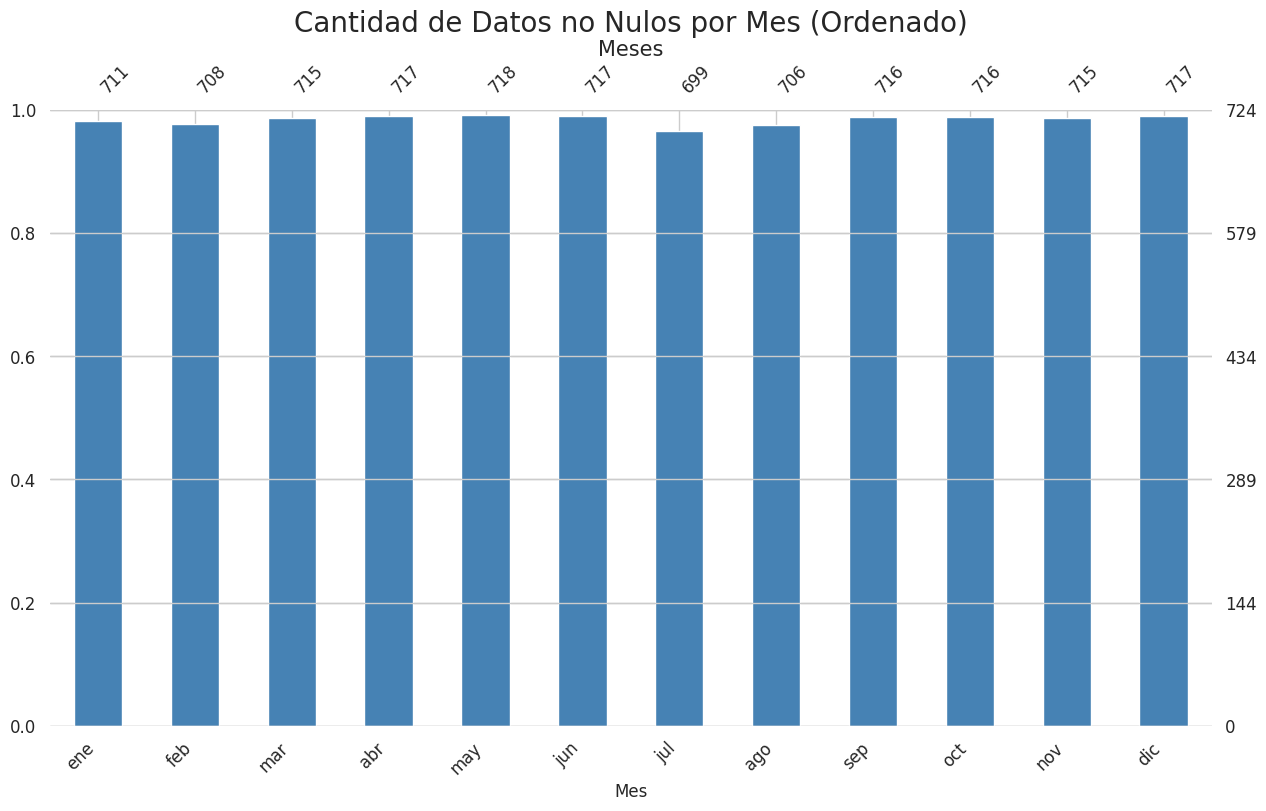

In [50]:
df_pivoted = df_enriquecido.pivot_table(
    index=['Estaci√≥n', 'Variable'],
    columns='Mes',
    values='Valor'
)
msno.bar(df_pivoted, fontsize=12, figsize=(15, 8), color='steelblue')
plt.title('Cantidad de Datos no Nulos por Mes (Ordenado)', fontsize=20)
plt.xlabel('Meses', fontsize=15)
plt.ylabel('Observaciones no nulas', fontsize=15)
plt.show()


<AxesSubplot: >

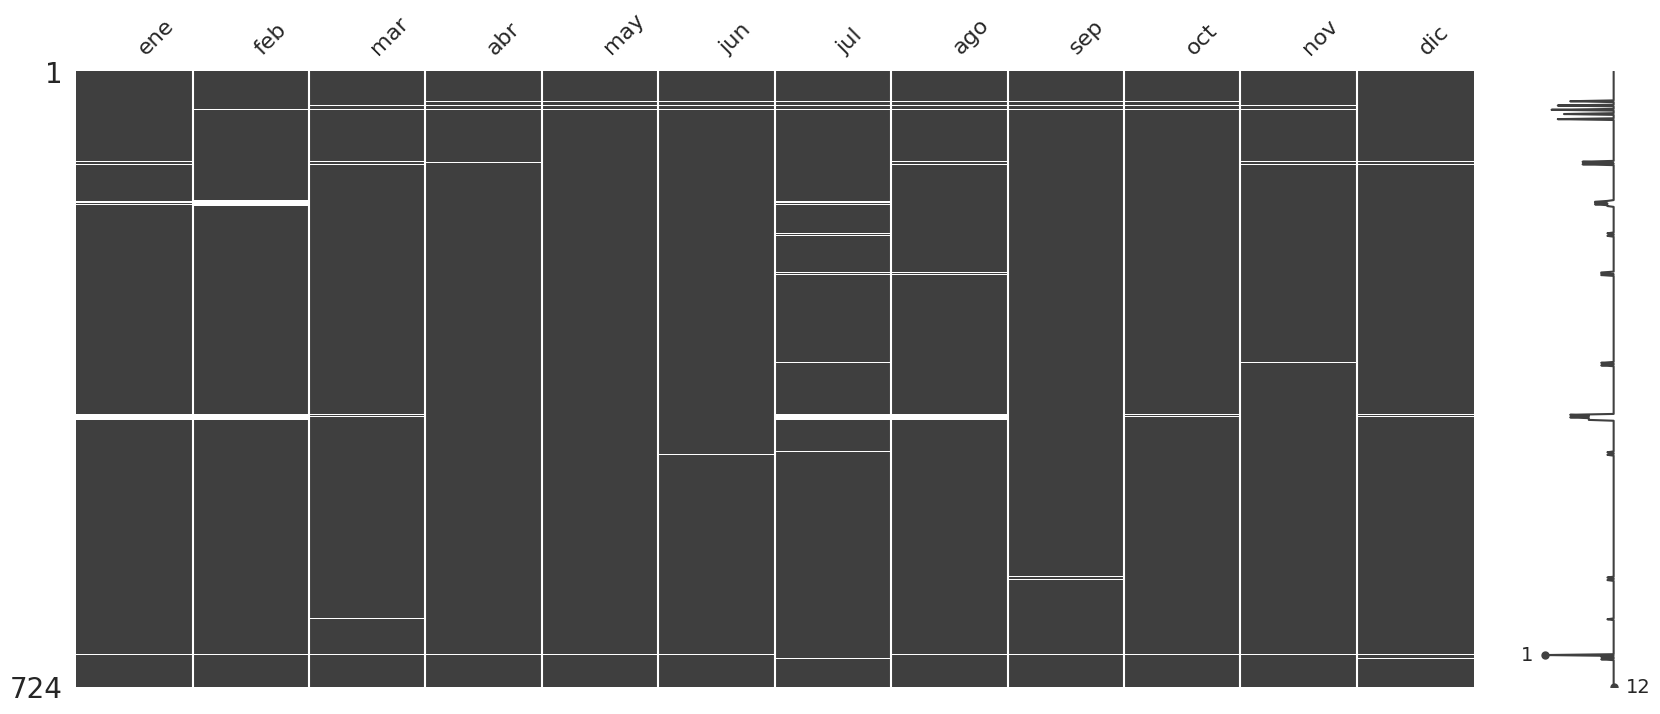

In [51]:
msno.matrix(df_pivoted, figsize=(20,8))

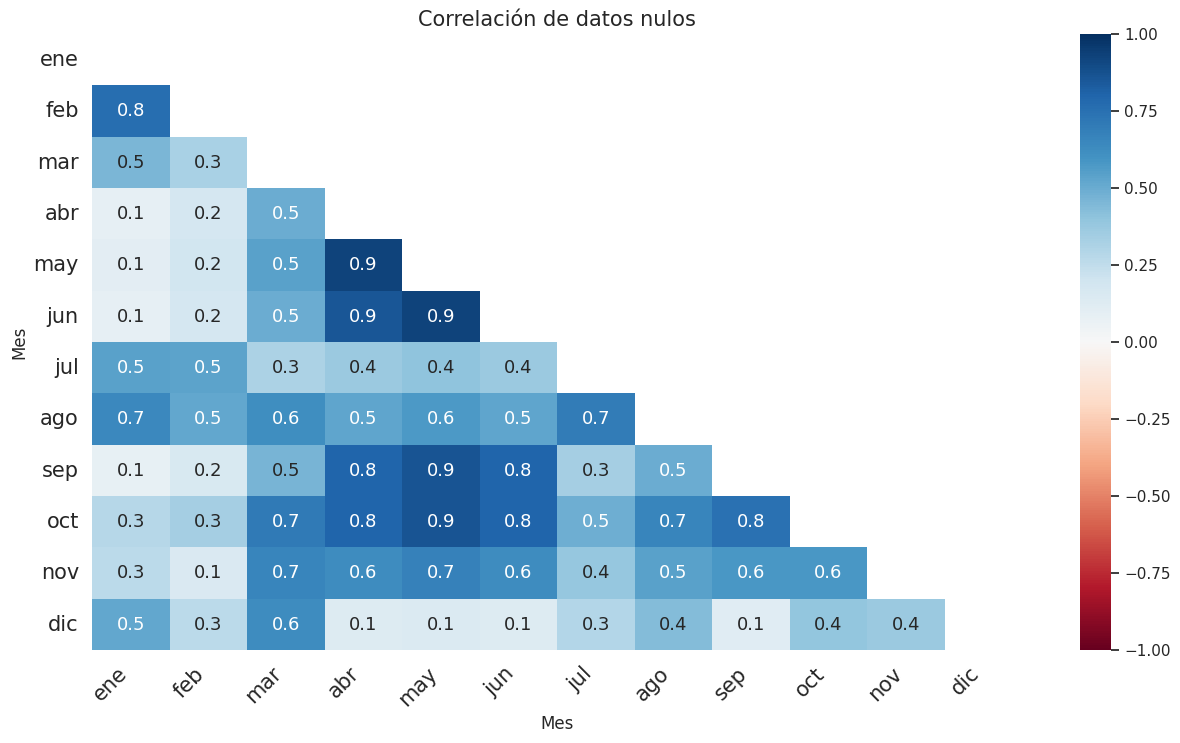

In [52]:
msno.heatmap(df_pivoted, fontsize=15, figsize=(15,8))
plt.title("Correlaci√≥n de datos nulos", fontsize=15)
plt.show()

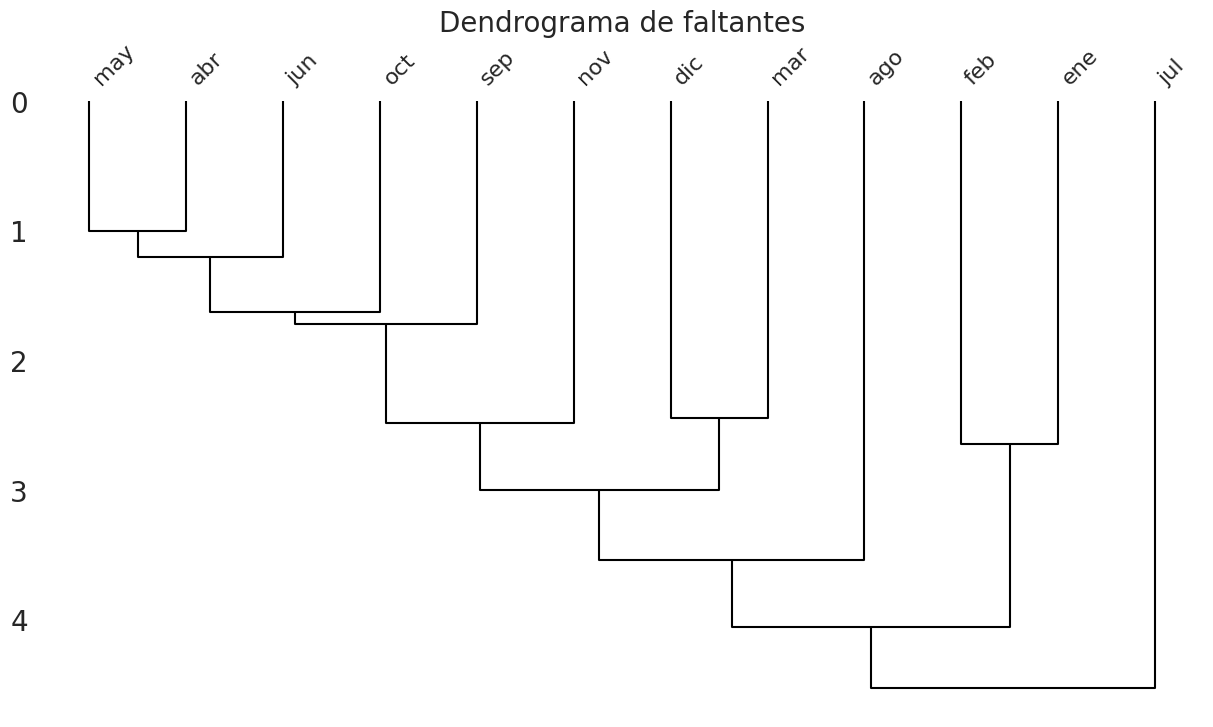

In [53]:
msno.dendrogram(df_pivoted, figsize=(15,8))
plt.title('Dendrograma de faltantes', fontsize=20)
plt.show()

In [54]:
def nulos_por_grupo(df, grupo_cols, target_col):
    agrupar_nulos = (
        df.groupby(grupo_cols, observed=True)[target_col]
        .apply(lambda x: x.isnull().mean() * 100)
        .reset_index(name=f'porcentaje_nulos_{target_col}')
    )
    return agrupar_nulos

# Ejemplos de an√°lisis para 'Valor' (re-generamos para tener los DataFrames)
nulos_valor_por_estacion = nulos_por_grupo(df_enriquecido, 'Estaci√≥n', 'Valor')
nulos_valor_por_variable = nulos_por_grupo(df_enriquecido, 'Variable', 'Valor')
nulos_valor_por_provincia = nulos_por_grupo(df_enriquecido, 'provincia', 'Valor')
nulos_valor_por_estacion_variable = nulos_por_grupo(df_enriquecido, ['Estaci√≥n', 'Variable'], 'Valor')

# --- C√≥mo ordenar de mayor a menor ---

print("--- Nulos en 'Valor' por Estaci√≥n (Ordenado de mayor a menor) ---")
nulos_age_por_estacion_ordenado = nulos_valor_por_estacion.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_age_por_estacion_ordenado, "\n")


print("--- Nulos en 'Valor' por Variable (Ordenado de mayor a menor) ---")
nulos_valor_por_variable_ordenado = nulos_valor_por_variable.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_valor_por_variable_ordenado, "\n")


print("--- Nulos en 'Valor' por provincia (Ordenado de mayor a menor) ---")
nulos_valor_por_provincia_ordenado = nulos_valor_por_provincia.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_valor_por_provincia_ordenado, "\n")


print("--- Nulos en 'Valor' por Estaci√≥n y Variable (Ordenado de mayor a menor) ---")
nulos_valor_por_estacion_variable_ordenado = nulos_valor_por_estacion_variable.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_valor_por_estacion_variable_ordenado, "\n")

--- Nulos en 'Valor' por Estaci√≥n (Ordenado de mayor a menor) ---
               Estaci√≥n  porcentaje_nulos_Valor
4      base_belgrano_ii               50.000000
7         base_marambio               47.916667
55                obera               47.916667
9       base_san_martin               46.875000
6        base_esperanza               46.875000
..                  ...                     ...
13       catamarca_aero                0.000000
15        chamical_aero                0.000000
2     bahia_blanca_aero                0.000000
3        bariloche_aero                0.000000
97  villa_reynolds_aero                0.000000

[98 rows x 2 columns] 

--- Nulos en 'Valor' por Variable (Ordenado de mayor a menor) ---
                               Variable  porcentaje_nulos_Valor
7                  velocidad_viento_kmh               39.795918
0  frecuencia_dias_precipitacion_gt_1mm                9.778912
3                      precipitacion_mm                9.778912
1        


# Tipos de datos faltantes

### 1. MAR (Missing at Random)
* **Qu√© es:** la falta del dato se explica por otra variable que s√≠ podemos observar.
* **Ejemplo:** la **velocidad del viento** falta por completo en la estaci√≥n **Or√°n Aero**, probablemente porque esa estaci√≥n no ten√≠a el equipamiento necesario. La ausencia depende de la variable `Estaci√≥n`.

### 2. MNAR (Missing Not at Random)
* **Qu√© es:** la falta del dato es causada por el propio valor que no se pudo medir.
* **Ejemplo:** un term√≥metro que se congela y deja de reportar datos solo cuando la temperatura es extremadamente baja. La ausencia depende del valor extremo que no se registr√≥.

### 3. MCAR (Missing Completely at Random)
* **Qu√© es:** la ausencia es puramente accidental y no tiene relaci√≥n con ninguna variable.
* **Ejemplo:** un error humano al anotar un √∫nico dato al azar. Es poco probable que explique los patrones sistem√°ticos de tus datos.

---

# Interpretaci√≥n detallada de los nulos por grupos

El orden de los resultados por porcentaje de nulos ofrece una visi√≥n clara y r√°pida de d√≥nde se concentran los valores faltantes en la columna `Valor`. A continuaci√≥n, se analiza cada agrupaci√≥n.

---

## üìä Nulos en 'Valor' por estaci√≥n


### An√°lisis
Se observa una clara concentraci√≥n de nulos en las **estaciones ant√°rticas** (`Base Belgrano II`, `Base Marambio`, `Base Esperanza`, `Base San Mart√≠n`) y `Obera`, con porcentajes de nulos extremadamente altos (entre 46.8% y 50%). Esto sugiere problemas cr√≥nicos de recolecci√≥n o transmisi√≥n de datos debido a su ubicaci√≥n remota o condiciones extremas. En contraste, muchas estaciones presentan un 0% de nulos.

### Implicaci√≥n
Los datos **no son MCAR** (Missing Completely At Random). La ausencia de datos en `Valor` est√° fuertemente condicionada por la `Estaci√≥n`. Es m√°s probable que sean **MNAR** (Missing Not At Random), porque las fallas en los equipos se relacionan directamente con las condiciones extremas que se intentan medir.

---

## üå°Ô∏è Nulos en 'Valor' por variable


### An√°lisis
Esta tabla es muy reveladora. La variable **`velocidad_viento_kmh` se destaca de forma dr√°stica con casi un 40% de nulos**. Las variables de precipitaci√≥n tambi√©n tienen un porcentaje notablemente alto (casi 10%), mientras que las de temperatura y nubosidad presentan muy pocos nulos.

### Implicaci√≥n
Nuevamente, los datos **no son MCAR**. La probabilidad de un valor nulo en `Valor` depende fuertemente de la `Variable` que se mide. Este es un fuerte indicio de **MAR**, donde la ausencia se explica por el tipo de medici√≥n. Por ejemplo, los anem√≥metros (medidores de viento) podr√≠an ser m√°s propensos a fallar que otros sensores.

---

## üá¶üá∑ Nulos en 'Valor' por provincia


### An√°lisis
La provincia de **Ant√°rtida** es, con diferencia, la que presenta la mayor proporci√≥n de nulos (casi 45%), lo cual es consistente con el an√°lisis por estaci√≥n. Le siguen **Chaco** y **Misiones**. Por otro lado, un gran n√∫mero de provincias no tienen ning√∫n valor nulo.

### Implicaci√≥n
Esto confirma que los datos **no son MCAR**. La `provincia` de origen es un factor muy importante que explica la presencia de nulos.

---

## üî¨ Nulos en 'Valor' por estaci√≥n y variable

### An√°lisis
Esta tabla ofrece la prueba m√°s contundente. Vemos que combinaciones espec√≠ficas de `Estaci√≥n` y `Variable` tienen un **100% de nulos**.

### Implicaci√≥n
Definitivamente, los datos **no son MCAR**. La ausencia es **sistem√°tica** y depende de la combinaci√≥n de *d√≥nde* (`Estaci√≥n`) y *qu√©* (`Variable`) se mide. Esto es un caso claro de **MAR** e incluso podr√≠a tener componentes de **MNAR**, si la falta de registro se debe a que la medici√≥n es imposible de obtener en ciertas condiciones.

---

## üìú Conclusi√≥n general

Con base en todos los an√°lisis, podemos afirmar con alta confianza que los datos faltantes en la columna `Valor` **no son MCAR**. La distribuci√≥n de los nulos es altamente dependiente de la `Estaci√≥n` y de la `Variable`.

Esto indica que el mecanismo de p√©rdida es **MAR (Missing At Random)**, ya que la probabilidad de que un valor falte se relaciona de forma sistem√°tica con otra informaci√≥n que s√≠ tenemos en el conjunto de datos.


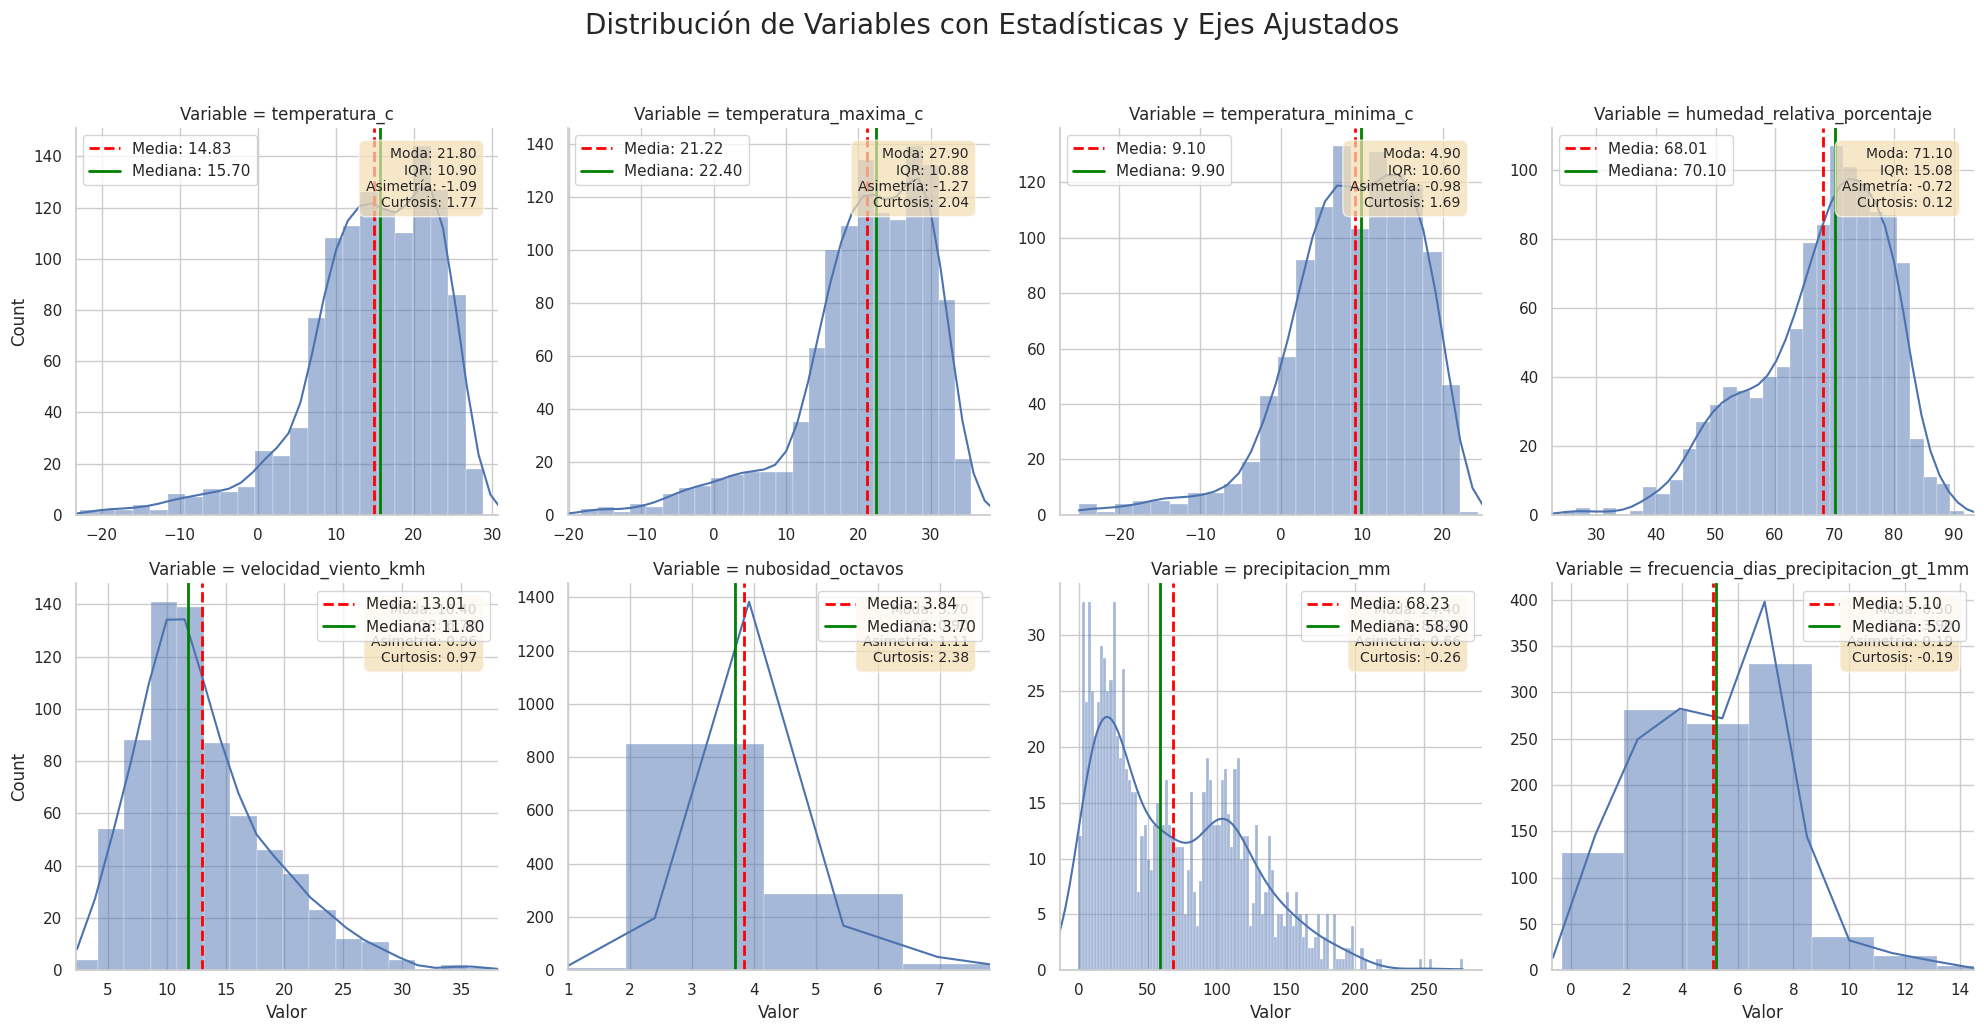

In [55]:
estadisticas_generales = df_enriquecido.groupby('Variable').agg(
    media=('Valor', 'mean'),
    mediana=('Valor', 'median'),
    moda=('Valor', mode),
    iqr=('Valor', iqr),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max') 
)

g = sns.displot(
    data=df_enriquecido,
    x='Valor',
    col='Variable',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_variable = titulo.split(' = ')[1]
    stats_variable = estadisticas_generales.loc[nombre_variable]

    if not stats_variable.empty:
        min_val = stats_variable['minimo']
        max_val = stats_variable['maximo']
        padding = (max_val - min_val) * 0.05
        ax.set_xlim(min_val - padding, max_val + padding)
        
        media = stats_variable['media']
        mediana = stats_variable['mediana']
        moda = stats_variable['moda']
        r_iqr = stats_variable['iqr']
        asim = stats_variable['asimetria_pearson']
        curt = stats_variable['curtosis_fisher']
        
        ax.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
        
        texto_stats = (
            f"Moda: {moda:.2f}\n"
            f"IQR: {r_iqr:.2f}\n"
            f"Asimetr√≠a: {asim:.2f}\n"
            f"Curtosis: {curt:.2f}"
        )
        
        ax.text(0.95, 0.95, texto_stats,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
        
        ax.legend()

g.fig.suptitle('Distribuci√≥n de Variables con Estad√≠sticas y Ejes Ajustados', y=1.03, fontsize=20)
g.tight_layout()
plt.show()

--- Estad√≠sticas para la provincia de: MENDOZA ---
                                          media  mediana  moda     iqr  asimetria_pearson  curtosis_fisher  minimo  maximo
Variable                                                                                                                  
frecuencia_dias_precipitacion_gt_1mm   2.933333     2.95   2.8   1.800           0.066931        -0.632993     0.6     5.4
humedad_relativa_porcentaje           56.086667    54.10  53.8  13.350           0.007384        -1.014701    40.0    70.4
nubosidad_octavos                      2.993333     2.95   2.7   0.500           0.495182        -0.135989     2.3     4.0
precipitacion_mm                      24.185000    23.85   3.1  20.650           0.339670        -0.806592     3.1    54.2
temperatura_c                         15.586667    15.95   7.4  10.725          -0.056774        -1.272642     3.8    25.9
temperatura_maxima_c                  23.191667    23.45  15.3  10.650          -0.0579

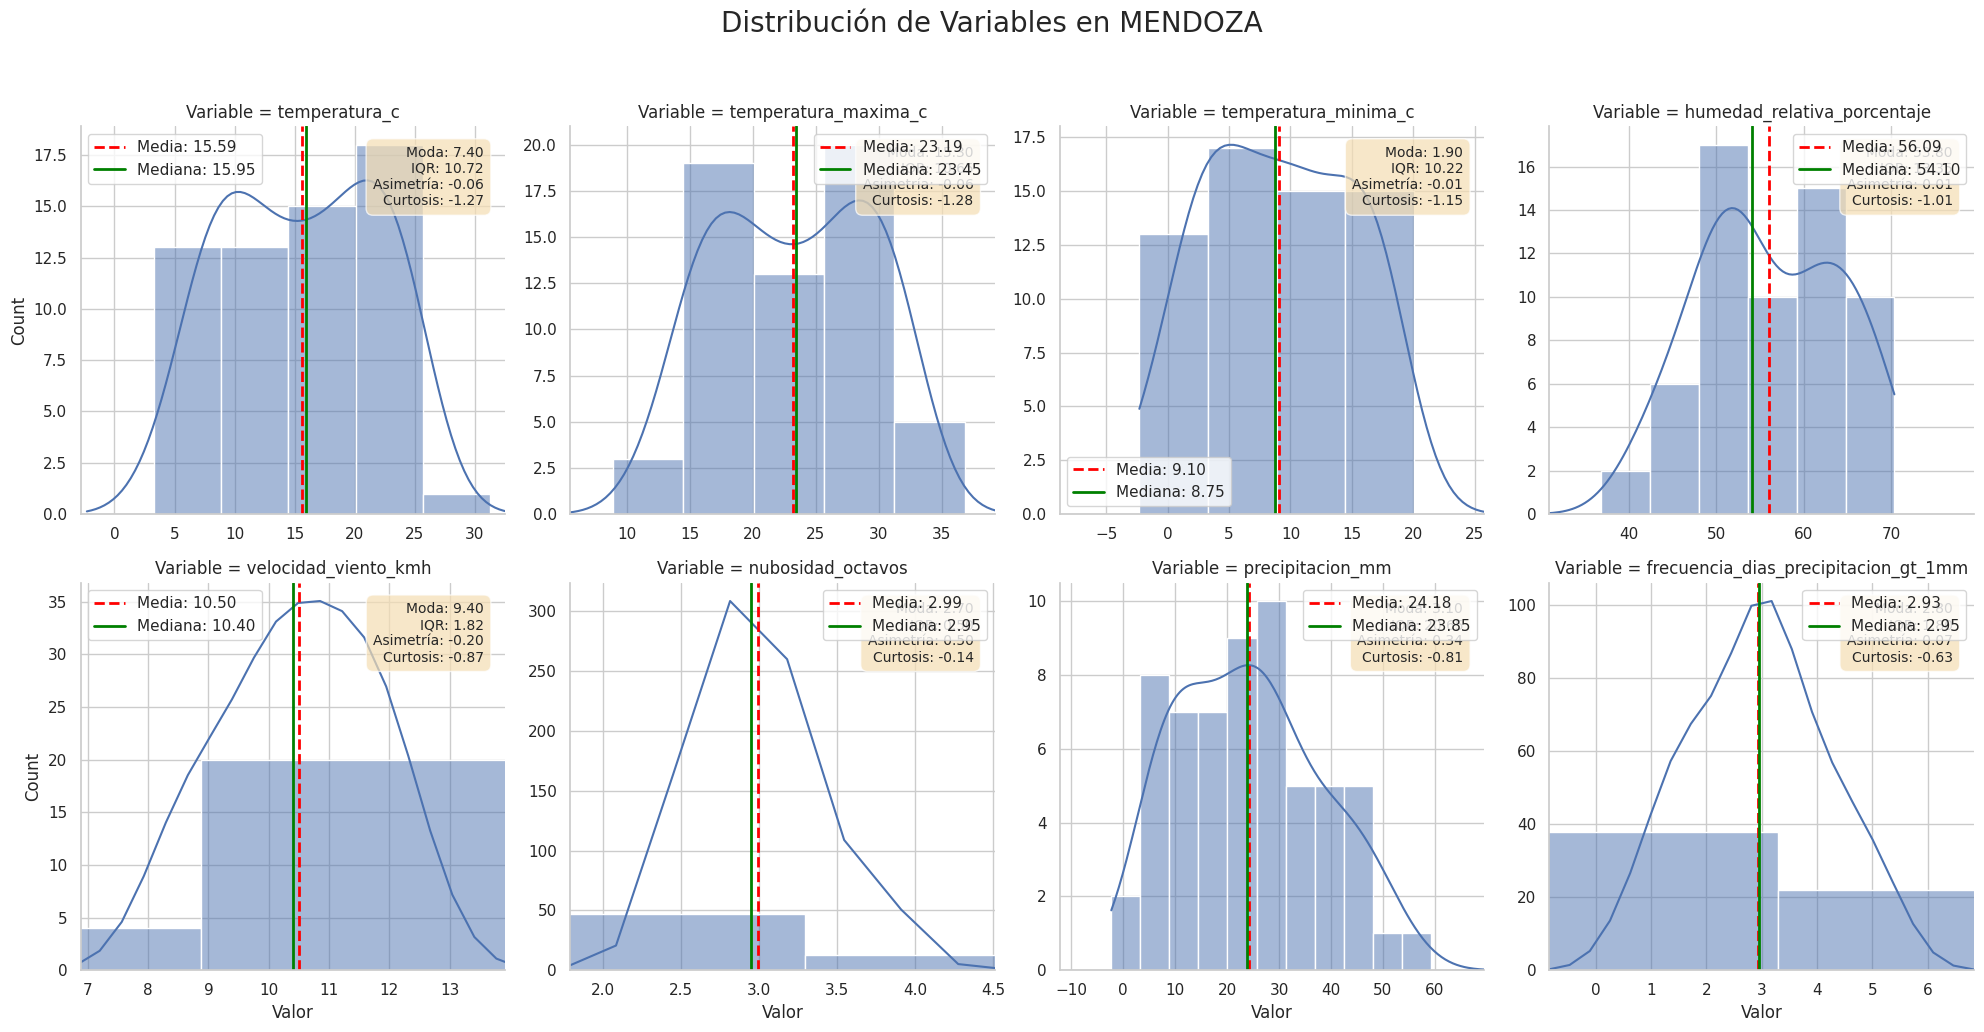

In [56]:
provincia_seleccionada = 'MENDOZA'  # Cambiar esto por la provincia que quieras analizar
df_provincia = df_enriquecido[df_enriquecido['provincia'] == provincia_seleccionada]

estadisticas_provincia = df_provincia.groupby('Variable').agg(
    media=('Valor', 'mean'),
    mediana=('Valor', 'median'),
    moda=('Valor', mode),
    iqr=('Valor', iqr),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max')
)

print(f"--- Estad√≠sticas para la provincia de: {provincia_seleccionada} ---")
print(estadisticas_provincia)


g = sns.displot(
    data=df_provincia,
    x='Valor',
    col='Variable',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_variable = titulo.split(' = ')[1]

    stats_variable = estadisticas_provincia.loc[nombre_variable]

    if not stats_variable.empty:
        min_val = stats_variable['minimo']
        max_val = stats_variable['maximo']
        padding = (max_val - min_val) * 0.30
        if padding == 0: padding = 1 
        ax.set_xlim(min_val - padding, max_val + padding)
        
        media = stats_variable['media']
        mediana = stats_variable['mediana']
        moda = stats_variable['moda']
        r_iqr = stats_variable['iqr']
        asim = stats_variable['asimetria_pearson']
        curt = stats_variable['curtosis_fisher']
        
        ax.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
        
        texto_stats = (
            f"Moda: {moda:.2f}\n"
            f"IQR: {r_iqr:.2f}\n"
            f"Asimetr√≠a: {asim:.2f}\n"
            f"Curtosis: {curt:.2f}"
        )
        
        ax.text(0.95, 0.95, texto_stats,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
        
        ax.legend()

g.fig.suptitle(f'Distribuci√≥n de Variables en {provincia_seleccionada}', y=1.03, fontsize=20)
g.tight_layout()
plt.show()


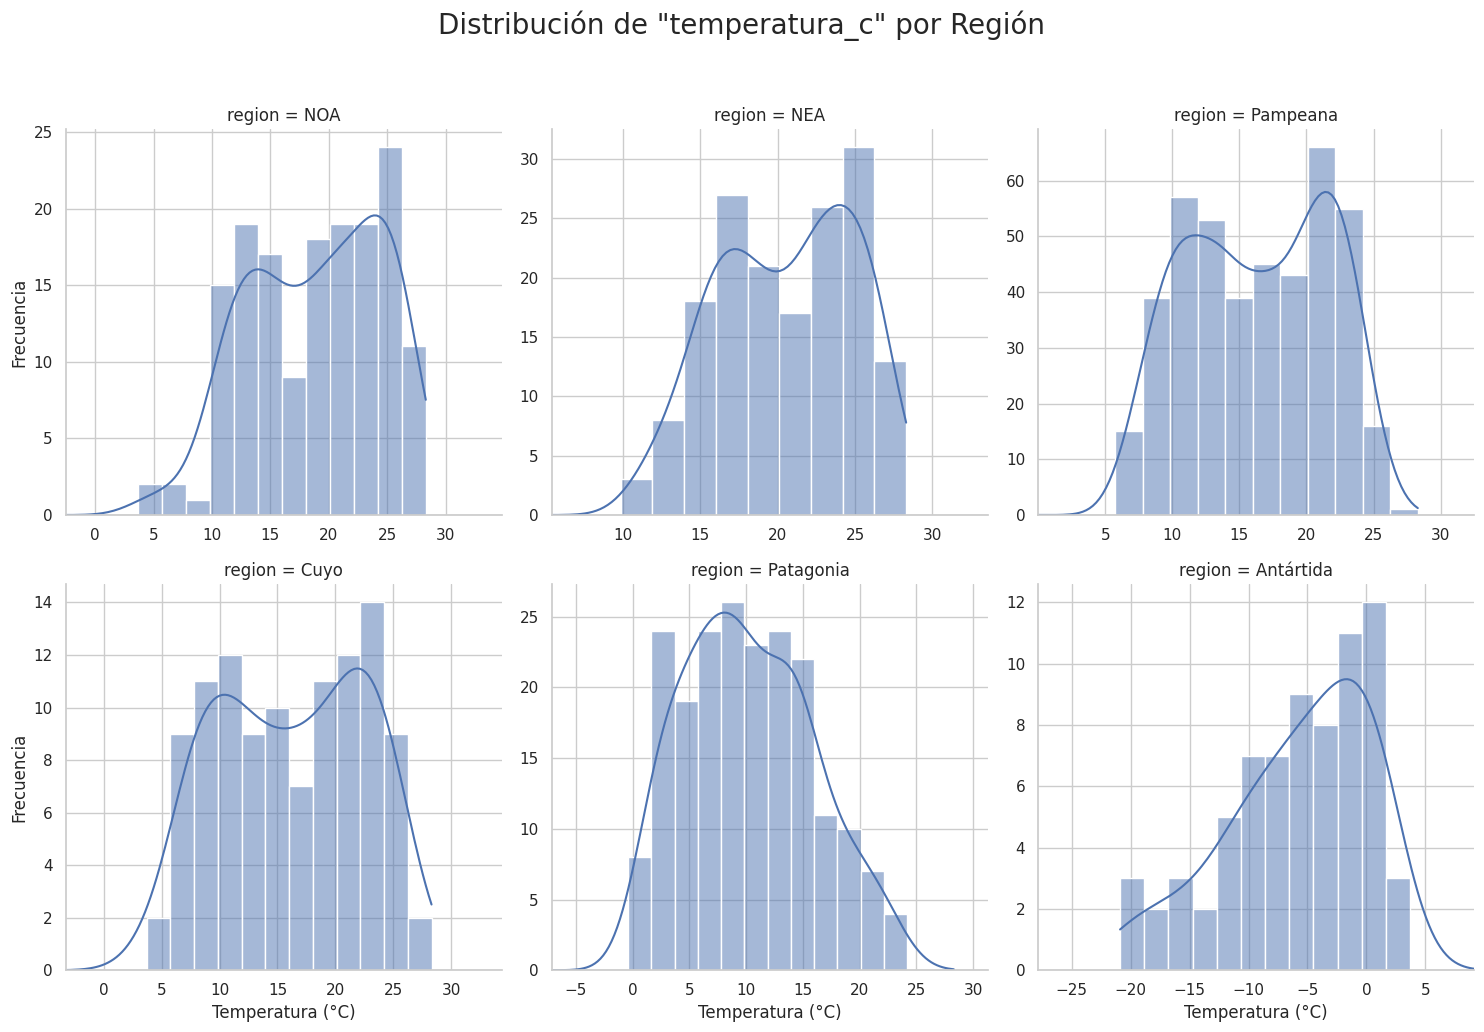

In [57]:
# 1. Filtrar para una sola variable de inter√©s
variable_a_analizar = 'temperatura_c'
df_filtrado_region = df_enriquecido[df_enriquecido['Variable'] == variable_a_analizar].copy()

# 2. Calcular los rangos (m√≠nimo y m√°ximo) para cada regi√≥n
rangos_por_region = df_filtrado_region.groupby('region')['Valor'].agg(['min', 'max'])

# 3. Crear el gr√°fico de distribuci√≥n con ejes independientes
g = sns.displot(
    data=df_filtrado_region,
    x='Valor',
    col='region',
    col_wrap=3,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False} # Ejes X independientes
)

# 4. Iterar sobre cada eje para ajustar la escala din√°micamente
for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_region = titulo.split(' = ')[1]

    if nombre_region in rangos_por_region.index:
        min_val = rangos_por_region.loc[nombre_region, 'min']
        max_val = rangos_por_region.loc[nombre_region, 'max']
        
        padding = (max_val - min_val) * 0.3
        
        ax.set_xlim(min_val - padding, max_val + padding)

# 5. Ajustar t√≠tulos y mostrar
g.fig.suptitle(f'Distribuci√≥n de "{variable_a_analizar}" por Regi√≥n', y=1.03, fontsize=20)
g.set_axis_labels("Temperatura (¬∞C)", "Frecuencia")
g.fig.tight_layout()
plt.show()

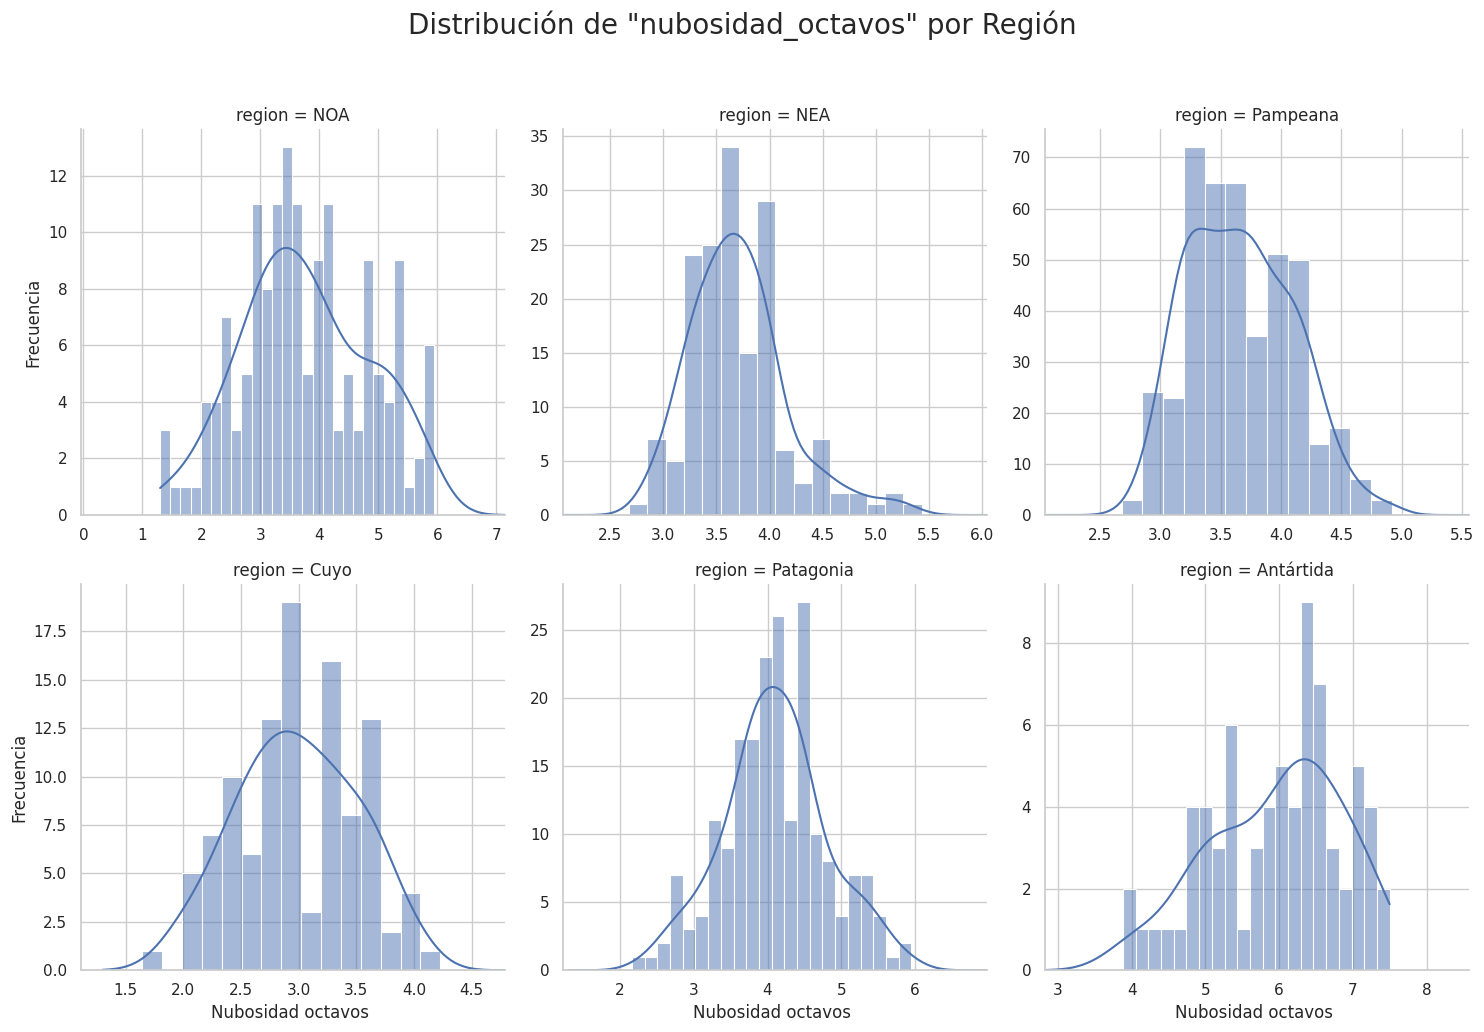

In [58]:
# 1. Filtrar para una sola variable de inter√©s
variable_a_analizar = 'nubosidad_octavos'
df_filtrado_region = df_enriquecido[df_enriquecido['Variable'] == variable_a_analizar].copy()

# 2. Calcular los rangos (m√≠nimo y m√°ximo) para cada regi√≥n
rangos_por_region = df_filtrado_region.groupby('region')['Valor'].agg(['min', 'max'])

# 3. Crear el gr√°fico de distribuci√≥n con ejes independientes
g = sns.displot(
    data=df_filtrado_region,
    x='Valor',
    col='region',
    col_wrap=3,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False} # Ejes X independientes
)

# 4. Iterar sobre cada eje para ajustar la escala din√°micamente
for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_region = titulo.split(' = ')[1]

    if nombre_region in rangos_por_region.index:
        min_val = rangos_por_region.loc[nombre_region, 'min']
        max_val = rangos_por_region.loc[nombre_region, 'max']
        
        padding = (max_val - min_val) * 0.3
        
        ax.set_xlim(min_val - padding, max_val + padding)

# 5. Ajustar t√≠tulos y mostrar
g.fig.suptitle(f'Distribuci√≥n de "{variable_a_analizar}" por Regi√≥n', y=1.03, fontsize=20)
g.set_axis_labels("Nubosidad octavos ", "Frecuencia")
g.fig.tight_layout()
plt.show()

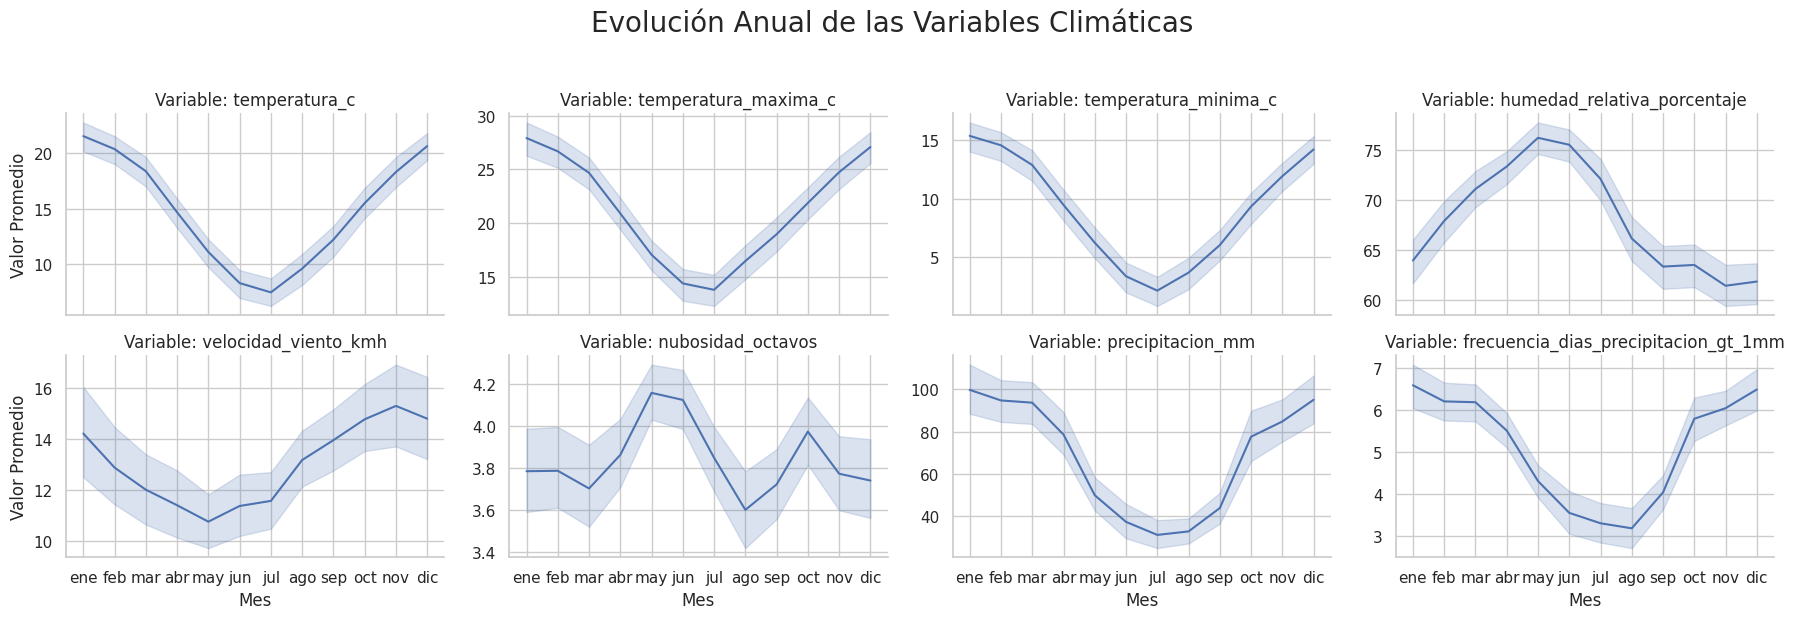

In [59]:
sns.set_theme(style="whitegrid")

g = sns.relplot(
    data=df_enriquecido,
    x='Mes',
    y='Valor',
    col='Variable',
    kind='line',
    col_wrap=4,
    height=3,
    aspect=1.5,
    facet_kws={'sharey': False, 'sharex': True}
)

g.fig.suptitle('Evoluci√≥n Anual de las Variables Clim√°ticas', y=1.03, fontsize=20)
g.set_titles("Variable: {col_name}")
g.set_axis_labels("Mes", "Valor Promedio")
plt.tight_layout()
plt.show()

## Descripci√≥n General de las Distribuciones de Variables Clim√°ticas

A continuaci√≥n, se presenta una descripci√≥n de la distribuci√≥n y comportamiento de las variables clim√°ticas, bas√°ndose en los gr√°ficos de distribuci√≥n y evoluci√≥n anual proporcionados.

### 1. Temperatura ($temperatura\_c$)

* **Evoluci√≥n Anual (General):** Sigue un patr√≥n estacional claro, con valores promedio bajos en invierno (julio) y altos en verano (enero-febrero). La banda sombreada indica una variabilidad considerable a lo largo del a√±o.
* **Distribuci√≥n General:** La distribuci√≥n general de la temperatura tiende a ser bimodal o presenta una ligera asimetr√≠a, con una cola m√°s larga hacia valores m√°s bajos. La media se sit√∫a alrededor de 14.83 ¬∞C y la mediana en 15.70 ¬∞C, sugiriendo una ligera asimetr√≠a negativa. El rango intercuart√≠lico (IQR) es de 10.98, indicando una dispersi√≥n moderada. La curtosis de 1.77 sugiere colas m√°s ligeras que una distribuci√≥n normal.
* **Distribuci√≥n en Mendoza:** En Mendoza, la distribuci√≥n de la temperatura ($temperatura\_c$) se centra alrededor de una media de 15.59 ¬∞C y una mediana de 15.95 ¬∞C. Presenta un IQR de 10.72 y una curtosis de -1.27, lo que indica una distribuci√≥n m√°s aplanada (platic√∫rtica) y posiblemente bimodal o con dos picos, uno alrededor de 10-15¬∞C y otro cerca de 20-25¬∞C. La asimetr√≠a es de -0.06, lo que sugiere una distribuci√≥n casi sim√©trica o ligeramente sesgada a la izquierda.
* **Distribuci√≥n por Regi√≥n:** La distribuci√≥n de temperatura var√≠a significativamente por regi√≥n.
    * **NOA, NEA, Pampeana y Cuyo:** Muestran distribuciones que parecen bimodales o con un rango amplio de temperaturas, reflejando las variaciones estacionales. Las temperaturas promedio son m√°s c√°lidas en estas regiones.
    * **Patagonia:** Presenta un rango de temperaturas m√°s bajas y una distribuci√≥n m√°s concentrada en valores fr√≠os, aunque con cierta variabilidad.
    * **Ant√°rtida:** Exhibe las temperaturas m√°s bajas y una distribuci√≥n notablemente sesgada hacia valores negativos, con un rango de temperatura mucho m√°s fr√≠o en comparaci√≥n con las dem√°s regiones.

### 2. Temperatura M√°xima ($temperatura\_maxima\_c$)

* **Evoluci√≥n Anual (General):** Al igual que la temperatura promedio, la temperatura m√°xima muestra una clara estacionalidad, alcanzando sus picos en los meses de verano y sus m√≠nimos en invierno.
* **Distribuci√≥n General:** La distribuci√≥n general de la temperatura m√°xima tiene una media de 21.22 ¬∞C y una mediana de 22.40 ¬∞C. El IQR es de 13.68, lo que indica una dispersi√≥n considerable. La asimetr√≠a de -0.08 sugiere una distribuci√≥n casi sim√©trica. La curtosis de -0.94 indica que la distribuci√≥n es m√°s aplanada (platic√∫rtica) que una normal.
* **Distribuci√≥n en Mendoza:** Para Mendoza, la temperatura m√°xima ($temperatura\_maxima\_c$) tiene una media de 23.19 ¬∞C y una mediana de 23.45 ¬∞C. El IQR es de 13.29, y la asimetr√≠a de -0.28 indica un ligero sesgo hacia valores m√°s bajos. La curtosis de -1.20 sugiere una distribuci√≥n m√°s aplanada que la normal.

### 3. Temperatura M√≠nima ($temperatura\_minima\_c$)

* **Evoluci√≥n Anual (General):** La temperatura m√≠nima tambi√©n sigue un patr√≥n estacional, con los valores m√°s bajos en invierno y los m√°s altos en verano.
* **Distribuci√≥n General:** La distribuci√≥n general de la temperatura m√≠nima muestra una media de 9.30 ¬∞C y una mediana de 9.90 ¬∞C. El IQR es de 10.60, indicando una dispersi√≥n similar a la temperatura m√°xima. La asimetr√≠a es de -0.08, sugiriendo una distribuci√≥n casi sim√©trica. La curtosis de -1.69 indica que es m√°s aplanada que una distribuci√≥n normal.
* **Distribuci√≥n en Mendoza:** La temperatura m√≠nima ($temperatura\_minima\_c$) en Mendoza presenta una media de 8.94 ¬∞C y una mediana de 8.75 ¬∞C. Con un IQR de 10.22 y una asimetr√≠a de -0.01, la distribuci√≥n es casi sim√©trica. La curtosis de -1.15 la hace m√°s aplanada que una distribuci√≥n normal.

### 4. Humedad Relativa ($humedad\_relativa\_porcentaje$)

* **Evoluci√≥n Anual (General):** La humedad relativa muestra una tendencia estacional inversa a la temperatura, con valores m√°s altos en los meses m√°s fr√≠os y m√°s bajos en los meses m√°s c√°lidos.
* **Distribuci√≥n General:** La distribuci√≥n general de la humedad relativa es multimodal o tiene una forma irregular. La media se encuentra en 68.01 % y la mediana en 70.10 %. El IQR de 13.08 indica una dispersi√≥n moderada. La asimetr√≠a de -0.22 sugiere un ligero sesgo hacia valores m√°s altos de humedad. La curtosis de 0.12 indica una forma similar a una normal o ligeramente m√°s puntiaguda.
* **Distribuci√≥n en Mendoza:** En Mendoza, la humedad relativa ($humedad\_relativa\_porcentaje$) tiene una media de 56.09 % y una mediana de 54.10 %. El IQR es de 10.98 y la asimetr√≠a de -1.01, lo que indica un sesgo significativo hacia valores m√°s altos de humedad. La curtosis de -1.01 sugiere una distribuci√≥n m√°s aplanada.

### 5. Velocidad del Viento ($velocidad\_viento\_kmh$)

* **Evoluci√≥n Anual (General):** La velocidad del viento presenta cierta estacionalidad, con valores ligeramente m√°s altos en primavera-verano y m√°s bajos en invierno.
* **Distribuci√≥n General:** La distribuci√≥n general de la velocidad del viento parece tener una cola larga hacia valores m√°s altos, indicando la ocurrencia de vientos fuertes ocasionales. La media es de 10.40 km/h y la mediana de 11.85 km/h. El IQR es de 6.94 y la asimetr√≠a de 0.96, confirmando un sesgo positivo (hacia la derecha). La curtosis de 0.97 indica colas m√°s pesadas que una normal.
* **Distribuci√≥n en Mendoza:** En Mendoza, la velocidad del viento ($velocidad\_viento\_kmh$) tiene una media de 10.50 km/h y una mediana de 10.40 km/h. El IQR es de 3.80, lo que sugiere una menor dispersi√≥n en comparaci√≥n con la distribuci√≥n general. La asimetr√≠a de 1.02 y una curtosis de 0.87 confirman un sesgo positivo y colas m√°s pesadas.

### 6. Nubosidad ($nubosidad\_octavos$)

* **Evoluci√≥n Anual (General):** La nubosidad muestra fluctuaciones a lo largo del a√±o, con valores ligeramente m√°s altos en los meses de invierno y primavera.
* **Distribuci√≥n General:** La distribuci√≥n general de la nubosidad es marcadamente asim√©trica, concentr√°ndose en valores bajos (poca nubosidad) y con una cola que se extiende hacia valores m√°s altos (mayor nubosidad). La media es de 3.70 octavos y la mediana de 3.84 octavos. El IQR de 1.90 y la asimetr√≠a de 0.70 reflejan este sesgo positivo. La curtosis de 3.38 indica una distribuci√≥n con un pico m√°s agudo y colas m√°s pesadas que una normal.
* **Distribuci√≥n en Mendoza:** La nubosidad ($nubosidad\_octavos$) en Mendoza tiene una media de 2.99 octavos y una mediana de 3.00 octavos, lo que sugiere cielos generalmente menos nublados que en el promedio general. El IQR es de 0.50, lo que indica una distribuci√≥n m√°s concentrada. La asimetr√≠a de 0.14 y una curtosis de -1.04 sugieren una distribuci√≥n m√°s sim√©trica y aplanada en comparaci√≥n con la distribuci√≥n general.

### 7. Precipitaci√≥n ($precipitacion\_mm$)

* **Evoluci√≥n Anual (General):** La precipitaci√≥n es altamente estacional, con los mayores vol√∫menes concentrados en los meses de verano (especialmente de diciembre a marzo) y m√≠nimos en invierno.
* **Distribuci√≥n General:** La distribuci√≥n general de la precipitaci√≥n est√° fuertemente sesgada hacia cero, con una gran cantidad de d√≠as sin precipitaci√≥n o con muy poca, y una larga cola hacia valores m√°s altos que representan eventos de lluvia intensos. La media es de 24.40 mm y la mediana de 68.22 mm. El IQR de 83.90 y la asimetr√≠a de 1.50 confirman un fuerte sesgo positivo. La curtosis de 0.26 indica colas m√°s pesadas que una normal.
* **Distribuci√≥n en Mendoza:** La precipitaci√≥n ($precipitacion\_mm$) en Mendoza tiene una media de 24.18 mm y una mediana de 23.85 mm. El IQR de 60.90 y la asimetr√≠a de 0.81 indican un sesgo positivo, aunque posiblemente menos pronunciado que en la distribuci√≥n general, reflejando el clima m√°s √°rido de la regi√≥n. La curtosis de -0.21 sugiere una distribuci√≥n ligeramente m√°s aplanada.

### 8. Frecuencia de D√≠as con Precipitaci√≥n > 1mm ($frecuencia\_dias\_precipitacion\_gt\_1mm$)

* **Evoluci√≥n Anual (General):** La frecuencia de d√≠as con precipitaci√≥n sigue un patr√≥n estacional similar a la precipitaci√≥n total, siendo m√°s alta en los meses de verano y m√°s baja en invierno.
* **Distribuci√≥n General:** La distribuci√≥n general de la frecuencia de d√≠as con precipitaci√≥n > 1mm tambi√©n est√° sesgada hacia valores bajos, indicando que los d√≠as con precipitaci√≥n significativa son menos frecuentes. La media es de 5.10 d√≠as y la mediana de 5.20 d√≠as. El IQR de 1.90 y la asimetr√≠a de 0.19 sugieren un ligero sesgo positivo. La curtosis de -0.10 indica una forma similar a una distribuci√≥n normal.
* **Distribuci√≥n en Mendoza:** La frecuencia de d√≠as con precipitaci√≥n > 1mm ($frecuencia\_dias\_precipitacion\_gt\_1mm$) en Mendoza tiene una media de 2.93 d√≠as y una mediana de 2.80 d√≠as. El IQR es de 0.83, lo que sugiere una menor variabilidad. La asimetr√≠a de 0.77 y una curtosis de 0.33 indican un sesgo positivo y colas ligeramente m√°s pesadas, lo que es consistente con una regi√≥n con menor frecuencia de lluvias significativas.

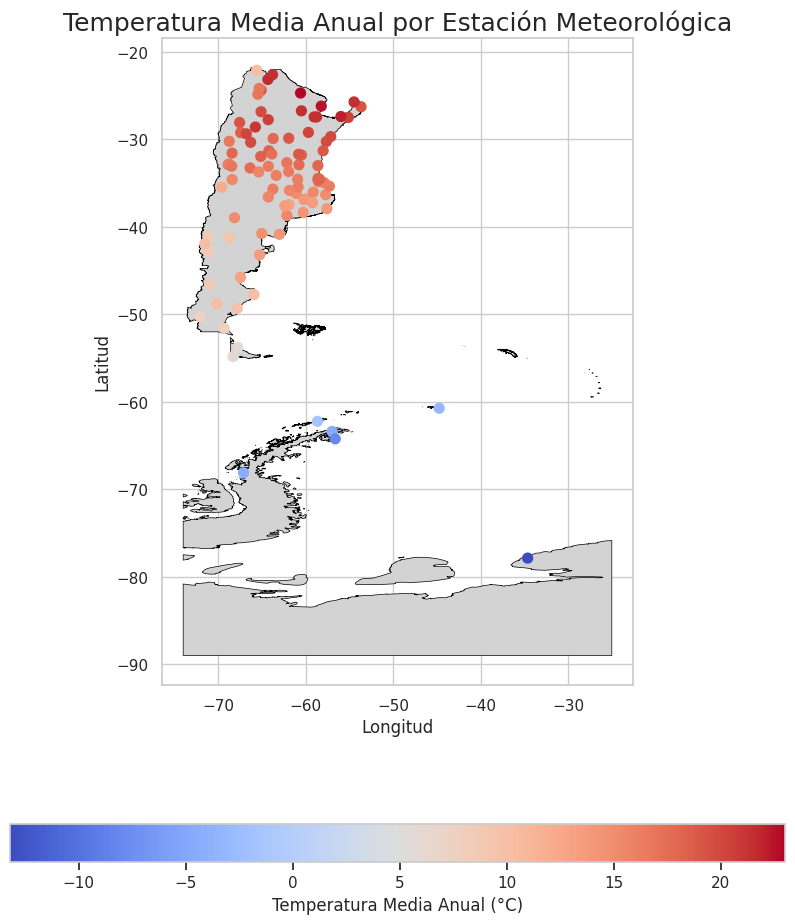

In [60]:

gdf_estaciones = geopandas.GeoDataFrame(
    df_bases, 
    geometry=geopandas.points_from_xy(df_bases.longitud, df_bases.latitud),
    crs="EPSG:4326"
)

# --- 2. Preparar los Datos a Visualizar ---
df_temperatura_media = df_enriquecido[df_enriquecido['Variable'] == 'temperatura_c'].groupby('Estaci√≥n')['Valor'].mean().reset_index()
df_temperatura_media.rename(columns={'Valor': 'temp_media_anual'}, inplace=True)
# --- 3. Unir Datos  ---
gdf_final_para_mapa = pd.merge(
    gdf_estaciones,
    df_temperatura_media,
    on='Estaci√≥n',
    how='inner'
)

# --- 4. Dibujar el Mapa ---
ruta_al_mapa = "datos/pais/paisPolygon.shp"  # <-- CAMBI√Å ESTA RUTA
argentina_mapa = geopandas.read_file(ruta_al_mapa)


# Creamos la figura y el eje del gr√°fico
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Dibujamos el mapa de provincias como base
argentina_mapa.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

# Superponemos los puntos de las estaciones
gdf_final_para_mapa.plot(
    column='temp_media_anual', 
    ax=ax, 
    legend=True,
    cmap='coolwarm',
    markersize=50,
    legend_kwds={'label': "Temperatura Media Anual (¬∞C)", 'orientation': "horizontal"}
)

# Configuramos el t√≠tulo y los ejes
ax.set_title('Temperatura Media Anual por Estaci√≥n Meteorol√≥gica', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

Columnas disponibles en el mapa final: Index(['gid', 'entidad', 'fna', 'gna', 'nam', 'in1', 'fdc', 'sag', 'geometry', 'provincia_limpia', 'provincia', 'temp_media_provincial'], dtype='object')


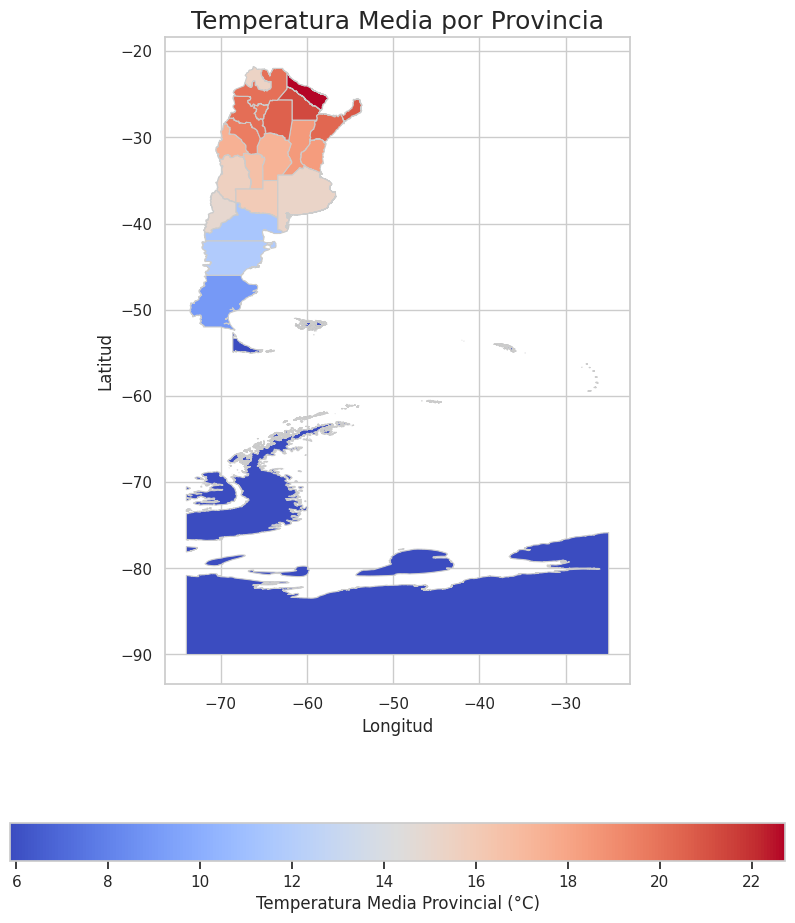

In [61]:
# a) Calcular la temperatura media por provincia
df_temp_provincia = df_enriquecido[df_enriquecido['Variable'] == 'temperatura_c'].groupby('provincia')['Valor'].mean().reset_index()

# b) Renombrar la columna 'Valor' a su nombre final
df_temp_provincia.rename(columns={'Valor': 'temp_media_provincial'}, inplace=True)

# c) Limpiar los nombres de las provincias para la uni√≥n
df_temp_provincia['provincia_limpia'] = df_temp_provincia['provincia'].apply(limpiar_texto)

mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_temp_provincia['provincia_limpia'] = df_temp_provincia['provincia_limpia'].replace(mapa_correcciones)


# --- 2. PREPARAR DATOS DEL MAPA ---

ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)


mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)


# --- 3. UNIR LOS DATAFRAMES ---

mapa_final = pd.merge(
    mapa_provincias,
    df_temp_provincia,
    on='provincia_limpia',
    how='left'
)


# --- 4. DIBUJAR EL MAPA ---

print("Columnas disponibles en el mapa final:", mapa_final.columns)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

mapa_final.plot(
    column='temp_media_provincial',
    ax=ax,
    legend=True,
    cmap='coolwarm',
    linewidth=0.8,
    edgecolor='0.8',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Sin datos",
    },
    legend_kwds={'label': "Temperatura Media Provincial (¬∞C)", 'orientation': "horizontal"}
)

ax.set_title('Temperatura Media por Provincia', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

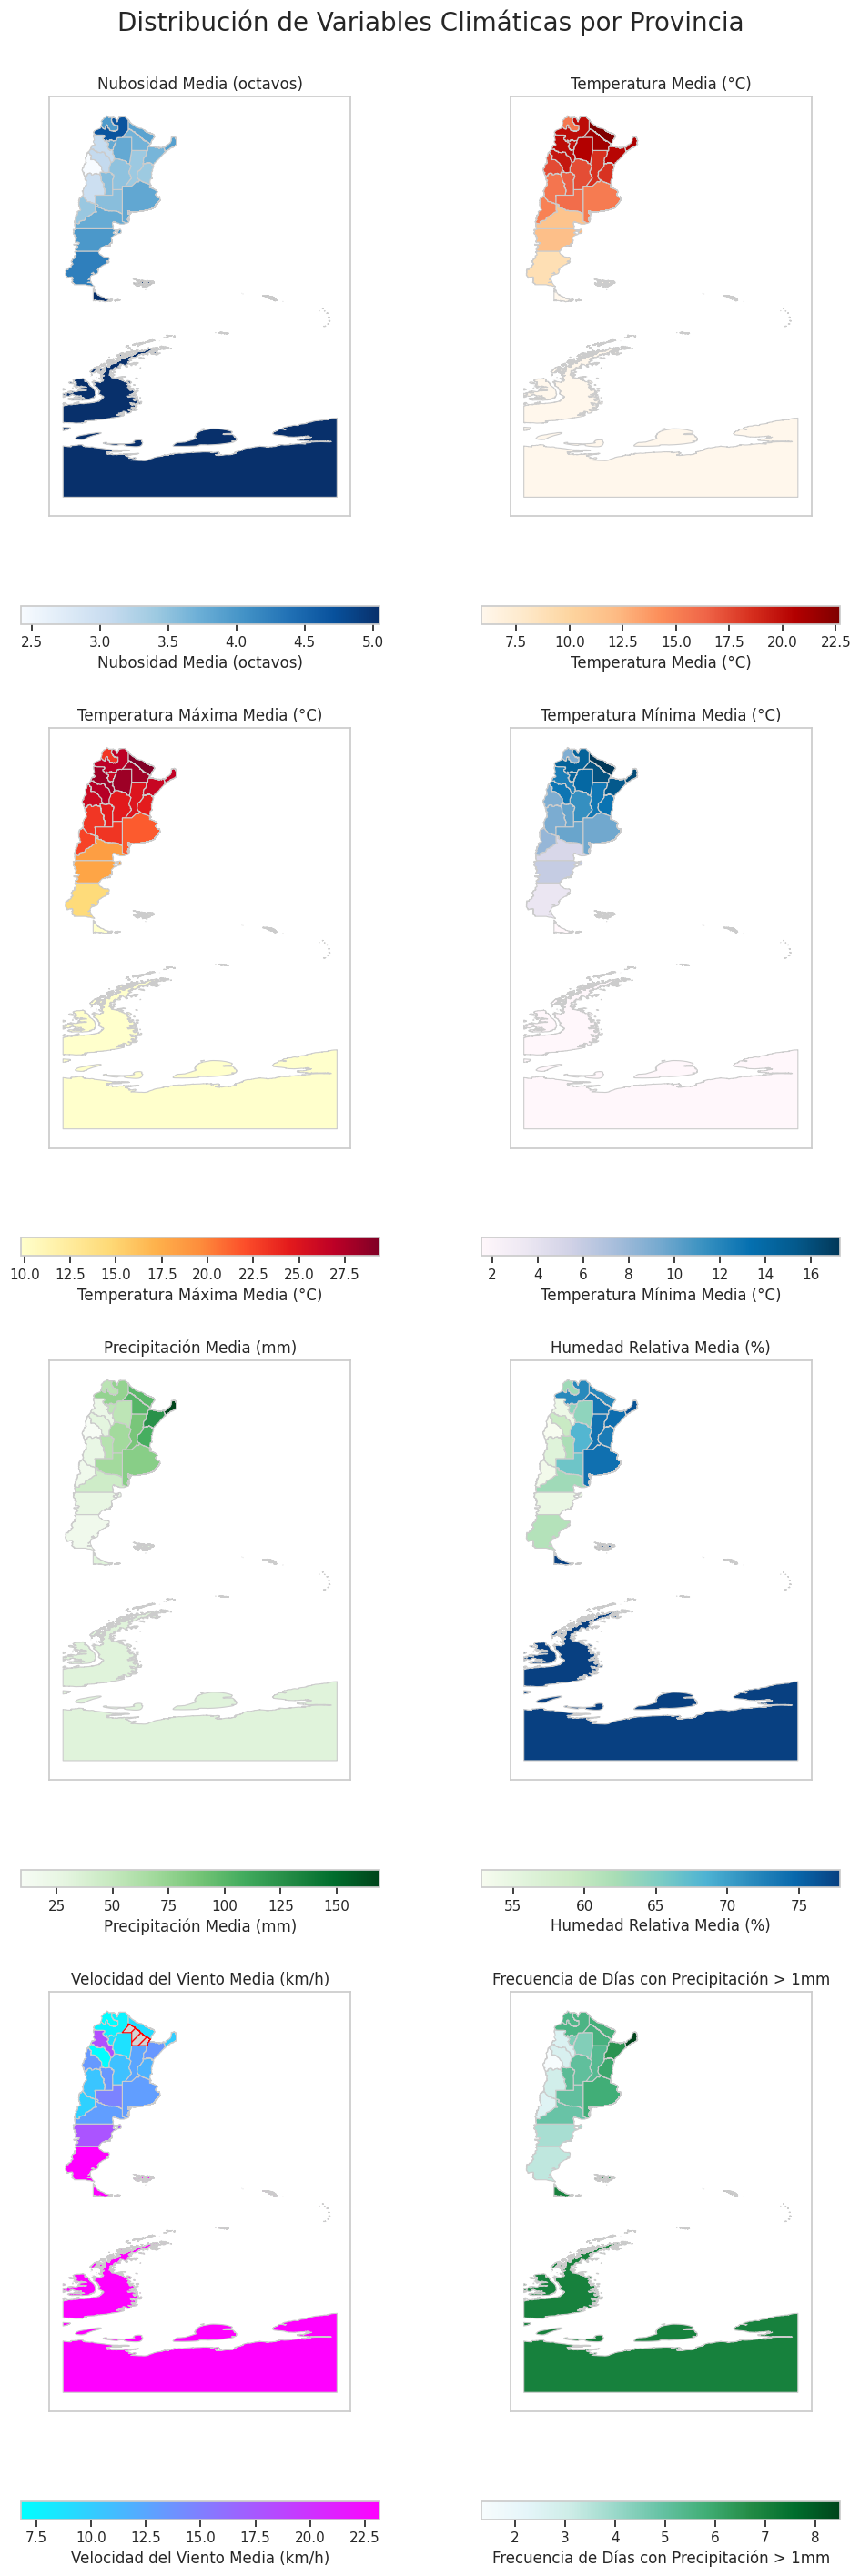

In [62]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt


# --- 1. PREPARAR DATOS DE NUBOSIDAD (como en tu c√≥digo original) ---
df_nubo_provincia = df_enriquecido[df_enriquecido['Variable'] == 'nubosidad_octavos'].groupby('provincia')['Valor'].mean().reset_index()
df_nubo_provincia.rename(columns={'Valor': 'nubo_media_provincial'}, inplace=True)
df_nubo_provincia['provincia_limpia'] = df_nubo_provincia['provincia'].apply(limpiar_texto)
mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_nubo_provincia['provincia_limpia'] = df_nubo_provincia['provincia_limpia'].replace(mapa_correcciones)

# --- 2. PREPARAR DATOS DEL MAPA (como en tu c√≥digo original) ---
ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)
mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)

# --- 3. DICCIONARIO DE VARIABLES A PLOTEAR Y SUS PROPIEDADES ---
variables_a_plotear = {
    'nubosidad_octavos': {
        'nombre_columna': 'nubo_media_provincial',
        'titulo': 'Nubosidad Media (octavos)',
        'cmap': 'Blues'
    },
      'temperatura_c': { 
        'nombre_columna': 'temp_media_provincial',
        'titulo': 'Temperatura Media (¬∞C)',
        'cmap': 'OrRd'
    },
    'temperatura_maxima_c': {
        'nombre_columna': 'temp_max_media_provincial',
        'titulo': 'Temperatura M√°xima Media (¬∞C)',
        'cmap': 'YlOrRd'
    },
    'temperatura_minima_c': {
        'nombre_columna': 'temp_min_media_provincial',
        'titulo': 'Temperatura M√≠nima Media (¬∞C)',
        'cmap': 'PuBu'
    },
    'precipitacion_mm': {
        'nombre_columna': 'precip_media_provincial',
        'titulo': 'Precipitaci√≥n Media (mm)',
        'cmap': 'Greens'
    },
    'humedad_relativa_porcentaje': {
        'nombre_columna': 'humedad_media_provincial',
        'titulo': 'Humedad Relativa Media (%)',
        'cmap': 'GnBu'
    },
    'velocidad_viento_kmh': {
        'nombre_columna': 'viento_media_provincial',
        'titulo': 'Velocidad del Viento Media (km/h)',
        'cmap': 'cool'
    },
    'frecuencia_dias_precipitacion_gt_1mm': {
        'nombre_columna': 'frec_precip_media_provincial',
        'titulo': 'Frecuencia de D√≠as con Precipitaci√≥n > 1mm',
        'cmap': 'BuGn'
    }
}

# --- 4. CREAR EL SUBPLOT DE MAPAS ---
n_variables = len(variables_a_plotear)
ncols = 2
nrows = (n_variables + ncols - 1) // ncols 

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 7)) # Ajusta el tama√±o de la figura
axes = axes.flatten() 

for i, (variable_original, props) in enumerate(variables_a_plotear.items()):
    ax = axes[i]

    # Prepara los datos para la variable actual
    df_variable_provincia = df_enriquecido[df_enriquecido['Variable'] == variable_original].groupby('provincia')['Valor'].mean().reset_index()
    df_variable_provincia.rename(columns={'Valor': props['nombre_columna']}, inplace=True)
    df_variable_provincia['provincia_limpia'] = df_variable_provincia['provincia'].apply(limpiar_texto)
    df_variable_provincia['provincia_limpia'] = df_variable_provincia['provincia_limpia'].replace(mapa_correcciones)

    # Une los dataframes
    mapa_final_variable = pd.merge(
        mapa_provincias,
        df_variable_provincia,
        on='provincia_limpia',
        how='left'
    )

    # Dibuja el mapa
    mapa_final_variable.plot(
        column=props['nombre_columna'],
        ax=ax,
        legend=True,
        cmap=props['cmap'],
        linewidth=0.8,
        edgecolor='0.8',
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Sin datos",
        },
        legend_kwds={'label': props['titulo'], 'orientation': "horizontal", 'shrink': 0.6} # Shrink para reducir el tama√±o de la leyenda
    )

    ax.set_title(props['titulo'], fontsize=12)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_aspect('equal')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Ajusta el layout para evitar solapamientos
plt.suptitle('Distribuci√≥n de Variables Clim√°ticas por Provincia', fontsize=20, y=1.02) # T√≠tulo general
plt.show()

In [63]:
#--- 1. Estad√≠sticas Generales por Variable ---
print("--- 1. Estad√≠sticas Generales por Variable ---")
estadisticas_generales = df_enriquecido.groupby('Variable').agg(
    conteo=('Valor', 'count'),
    media=('Valor', 'mean'),
    desvio_est=('Valor', 'std'),
    varianza=('Valor', 'var'),
    mediana=('Valor', 'median'),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max'),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt)
)
print(estadisticas_generales)

print("\n--- Moda por Variable ---")
moda_general = df_enriquecido.groupby('Variable')['Valor'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
print(moda_general)


# --- 2. Estad√≠sticas por Regi√≥n y Variable ---
print("\n" + "="*80)
print("--- 2. Estad√≠sticas por Regi√≥n y Variable ---")
estadisticas_por_region = df_enriquecido.groupby(['region', 'Variable']).agg(
    conteo=('Valor', 'count'),
    media=('Valor', 'mean'),
    desvio_est=('Valor', 'std'),
    varianza=('Valor', 'var'),
    mediana=('Valor', 'median'),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max'),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt)
)
print(estadisticas_por_region)

--- 1. Estad√≠sticas Generales por Variable ---
                                      conteo      media  desvio_est     varianza  mediana  minimo  maximo  asimetria_pearson  curtosis_fisher
Variable                                                                                                                                     
frecuencia_dias_precipitacion_gt_1mm    1061   5.097455    2.536586     6.434267      5.2     0.0    13.8           0.185539        -0.186138
humedad_relativa_porcentaje             1110  68.005405   11.027475   121.605201     70.1    25.7    90.2          -0.719815         0.118628
nubosidad_octavos                       1166   3.840137    0.888284     0.789049      3.7     1.3     7.5           1.109340         2.384159
precipitacion_mm                        1061  68.234873   51.674519  2670.255915     58.9     0.0   277.9           0.663766        -0.262990
temperatura_c                           1167  14.834190    8.178787    66.892561     15.7   -20.9   

## Outlaiers

/home/tomas/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


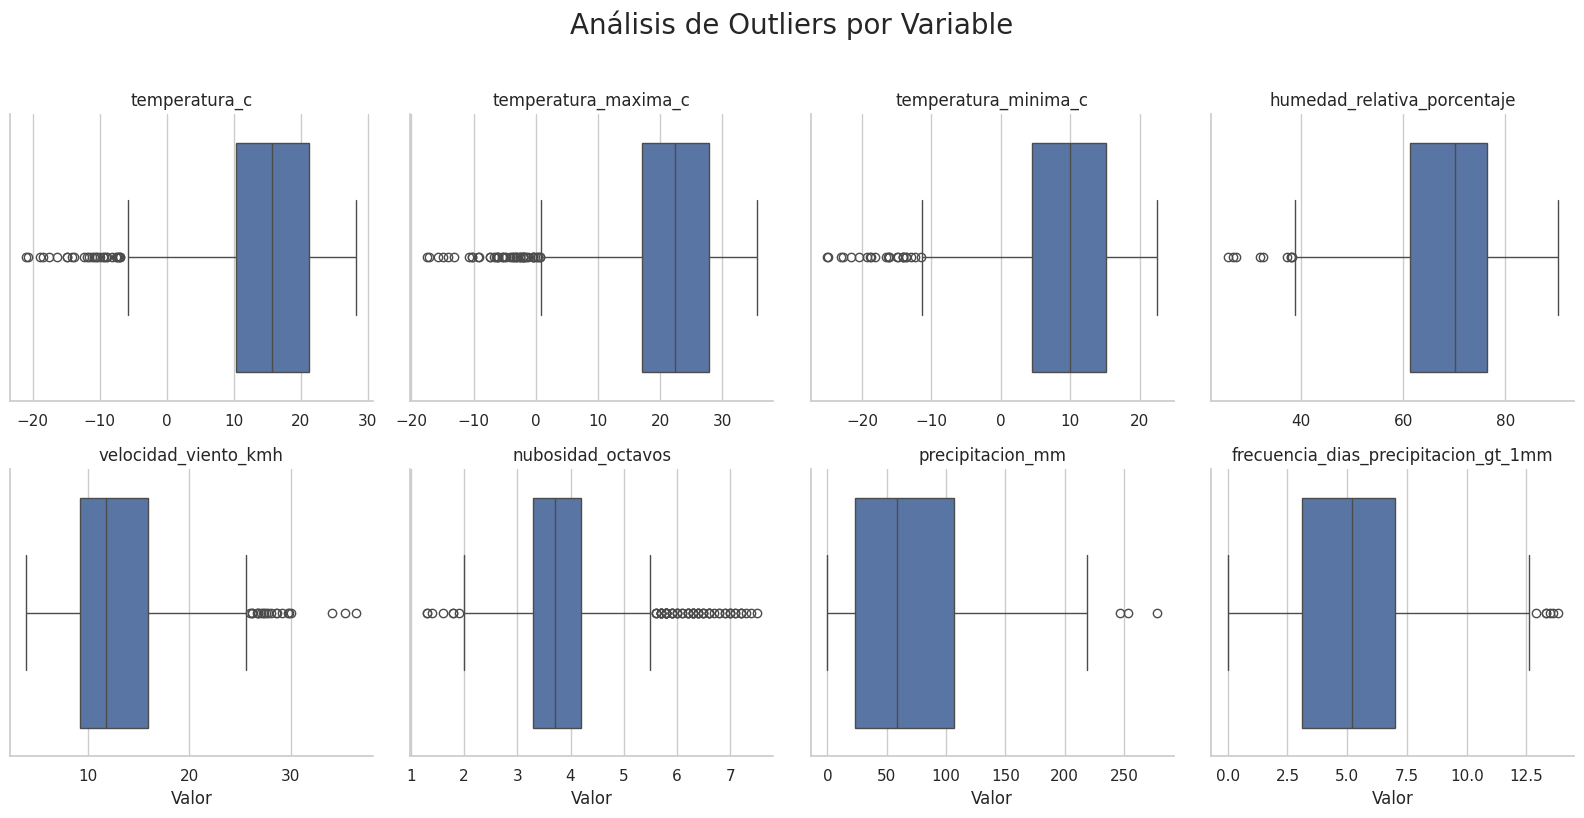

In [64]:
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(
    df_enriquecido, 
    col="Variable", 
    col_wrap=4, 
    sharey=False, 
    sharex=False, 
    height=4
)

g.map(sns.boxplot, "Valor")

g.set_axis_labels("Valor", "")
g.set_titles("{col_name}")
g.fig.suptitle("An√°lisis de Outliers por Variable", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [65]:
Q1 = df_enriquecido.groupby('Variable')['Valor'].quantile(0.25)
Q3 = df_enriquecido.groupby('Variable')['Valor'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

limites = pd.DataFrame({'lim_inf': limite_inferior, 'lim_sup': limite_superior})
print("--- L√≠mites para detecci√≥n de outliers por Variable ---")
print(limites)

df_con_limites = pd.merge(df_enriquecido, limites, on='Variable', how='left')

outliers_generales = df_con_limites[
    (df_con_limites['Valor'] < df_con_limites['lim_inf']) | 
    (df_con_limites['Valor'] > df_con_limites['lim_sup'])
]

conteo_de_outliers = outliers_generales['Variable'].value_counts()

total_por_variable = df_enriquecido['Variable'].value_counts()

resumen_outliers = pd.DataFrame({
    'total_registros': total_por_variable,
    'cantidad_outliers': conteo_de_outliers
}).fillna(0)

resumen_outliers['porcentaje_outliers'] = (resumen_outliers['cantidad_outliers'] / resumen_outliers['total_registros']) * 100

print("\n--- Resumen Porcentual de Outliers por Variable ---")
print(resumen_outliers)

--- L√≠mites para detecci√≥n de outliers por Variable ---
                                       lim_inf   lim_sup
Variable                                                
frecuencia_dias_precipitacion_gt_1mm   -2.7500   12.8500
humedad_relativa_porcentaje            38.7125   99.0125
nubosidad_octavos                       1.9500    5.5500
precipitacion_mm                     -101.5000  231.3000
temperatura_c                          -6.0500   37.5500
temperatura_maxima_c                    0.7125   44.2125
temperatura_minima_c                  -11.4000   31.0000
velocidad_viento_kmh                   -0.8500   25.9500

--- Resumen Porcentual de Outliers por Variable ---
                                      total_registros  cantidad_outliers  porcentaje_outliers
Variable                                                                                     
frecuencia_dias_precipitacion_gt_1mm             1176                  6             0.510204
humedad_relativa_porcentaje          


--- Regiones encontradas: NOA, NEA, Pampeana, Cuyo, nan, Patagonia, Ant√°rtida ---


/home/tomas/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/tomas/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/tomas/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/tomas/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and 

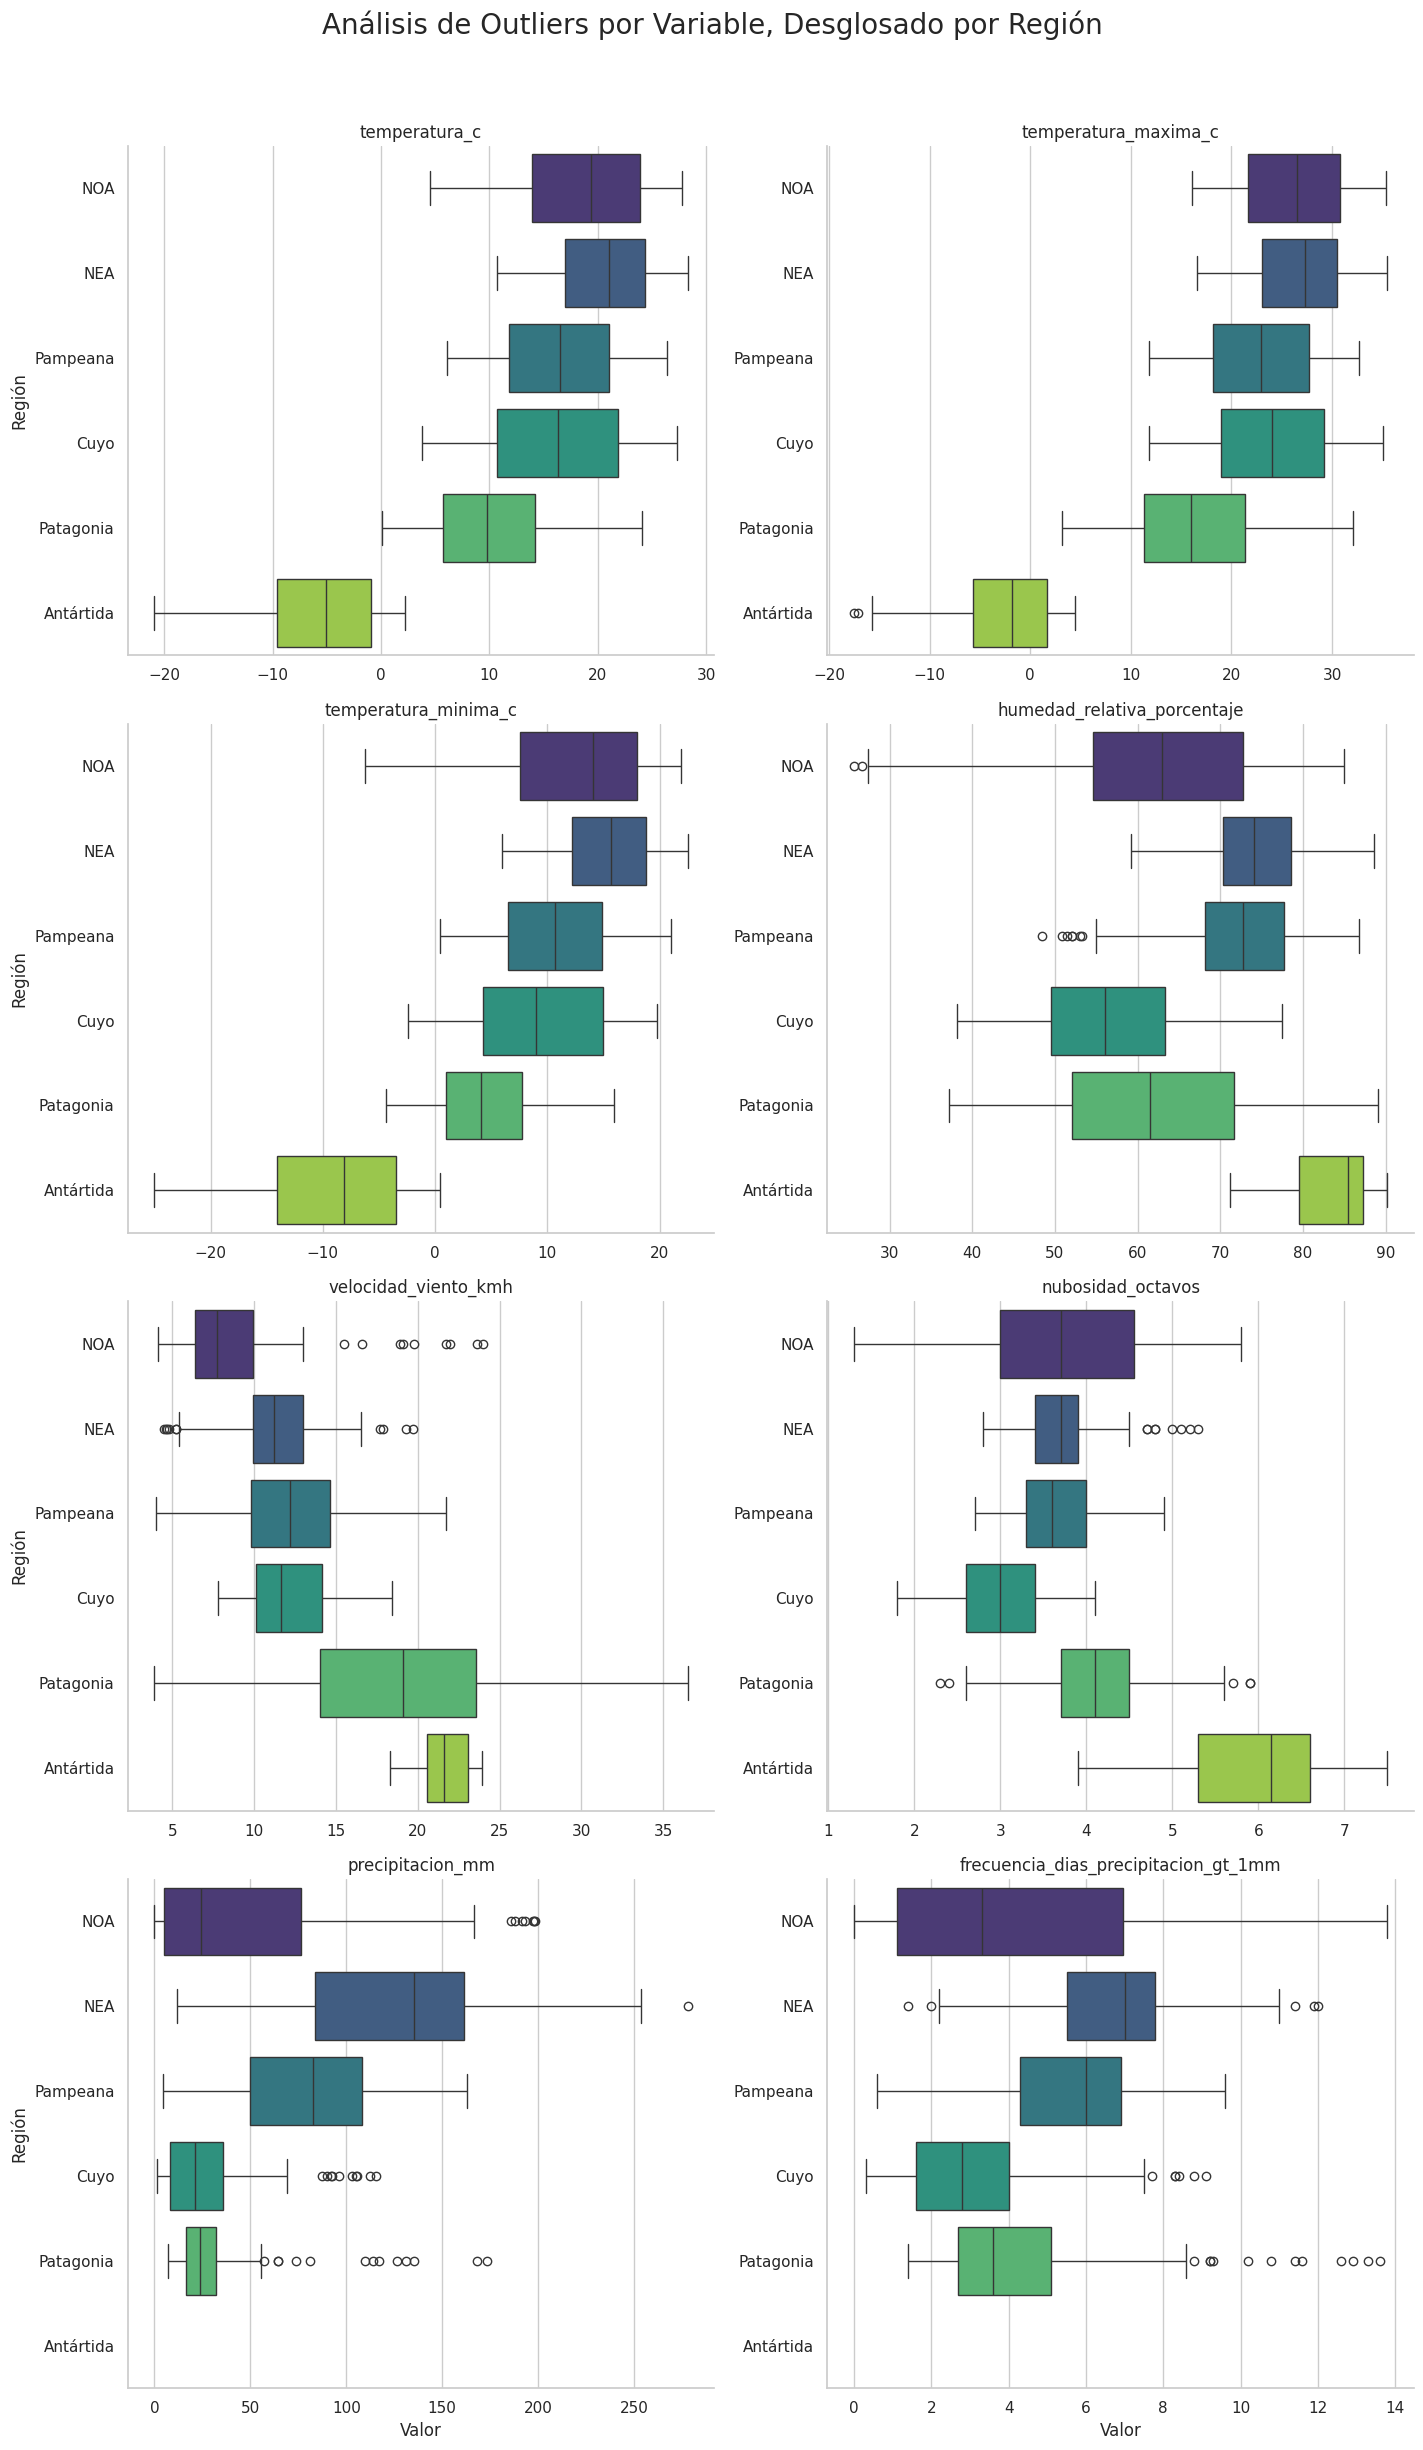

In [66]:
sns.set_theme(style="whitegrid")
regiones= df_enriquecido['region'].astype(str).unique()
print(f"\n--- Regiones encontradas: {', '.join(regiones)} ---")
g = sns.FacetGrid(
    df_enriquecido, 
    col="Variable", 
    col_wrap=2,  
    sharex=False, 
    sharey=False, 
    height=6,   
    aspect=1.2
)


g.map(sns.boxplot, 'Valor', 'region', palette='viridis')
g.set_axis_labels("Valor", "Regi√≥n")
g.set_titles("{col_name}")
g.fig.suptitle("An√°lisis de Outliers por Variable, Desglosado por Regi√≥n", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [67]:
# Calculamos los l√≠mites agrupando por regi√≥n Y variable
Q1_region = df_enriquecido.groupby(['region', 'Variable'])['Valor'].quantile(0.25)
Q3_region = df_enriquecido.groupby(['region', 'Variable'])['Valor'].quantile(0.75)
IQR_region = Q3_region - Q1_region

# Calculamos los l√≠mites inferior y superior
lim_inf_region = Q1_region - 1.5 * IQR_region
lim_sup_region = Q3_region + 1.5 * IQR_region 

# Creamos un DataFrame con los l√≠mites
limites_region = pd.DataFrame({'lim_inf': lim_inf_region, 'lim_sup': lim_sup_region}).reset_index()
limites_region.head()
# Unimos los l√≠mites al DataFrame original
df_con_limites_region = pd.merge(df_enriquecido, limites_region, on=['region', 'Variable'], how='left')

# Filtramos los outliers usando los l√≠mites corregidos
outliers_region = df_con_limites_region[
    (df_con_limites_region['Valor'] < df_con_limites_region['lim_inf']) | 
    (df_con_limites_region['Valor'] > df_con_limites_region['lim_sup'])
]

conteo_outliers_region = outliers_region.groupby(['region', 'Variable']).size()
total_por_region = df_enriquecido.groupby(['region', 'Variable']).size()

resumen_outliers_region = pd.DataFrame({
    'total_registros': total_por_region,
    'cantidad_outliers': conteo_outliers_region
}).fillna(0)

resumen_outliers_region['porcentaje_outliers'] = \
    (resumen_outliers_region['cantidad_outliers'] / resumen_outliers_region['total_registros']) * 100

print("\n--- Resumen Porcentual de Outliers por Regi√≥n ---")
print(resumen_outliers_region)


--- Resumen Porcentual de Outliers por Regi√≥n ---
                                                total_registros  cantidad_outliers  porcentaje_outliers
region    Variable                                                                                     
Ant√°rtida frecuencia_dias_precipitacion_gt_1mm               72                0.0             0.000000
          humedad_relativa_porcentaje                        72                0.0             0.000000
          nubosidad_octavos                                  72                0.0             0.000000
          precipitacion_mm                                   72                0.0             0.000000
          temperatura_c                                      72                0.0             0.000000
          temperatura_maxima_c                               72                2.0             2.777778
          temperatura_minima_c                               72                0.0             0.000000
          v

## 1. L√≠mites de Detecci√≥n

A continuaci√≥n, se presentan los l√≠mites calculados para cada variable:

--- L√≠mites para detecci√≥n de outliers por Variable ---

| Variable                               | lim_inf | lim_sup |
|----------------------------------------|---------|---------|
| frecuencia_dias_precipitacion_gt_1mm  | -2.7500 | 12.8500 |
| humedad_relativa_porcentaje            | 38.7125 | 99.0125 |
| nubosidad_octavos                      | 1.9500  | 5.5500  |
| precipitacion_mm                       | -101.5000 | 231.3000 |
| temperatura_c                          | -6.0500 | 37.5500 |
| temperatura_maxima_c                   | 0.7125  | 44.2125 |
| temperatura_minima_c                   | -11.4000 | 31.0000 |
| velocidad_viento_kmh                   | -0.8500 | 25.9500 |

## 2. An√°lisis General de Outliers por Variable

**Observaciones:**

* **`nubosidad_octavos`** presenta el mayor porcentaje de outliers (5.87%), sugiriendo variaciones considerables en la cobertura nubosa.
* Las variables de temperatura (`temperatura_maxima_c`, `temperatura_c`, `temperatura_minima_c`) tambi√©n muestran una cantidad notable de outliers, indicando registros de temperaturas inusualmente altas o bajas.
* **`precipitacion_mm`** tiene el menor porcentaje de outliers (0.26%), lo cual es esperable, ya que las precipitaciones extremadamente altas son eventos menos frecuentes.

## 3. An√°lisis de Outliers Desglosado por Regi√≥n

### Diferencias Clave en los Outliers entre Regiones:

Las regiones presentan patrones distintivos en la aparici√≥n de outliers, lo que subraya la diversidad clim√°tica del pa√≠s:

* **Ant√°rtida:** Destaca por la casi total ausencia de outliers, con la excepci√≥n de `temperatura_maxima_c`. Esto sugiere una menor variabilidad en sus condiciones clim√°ticas en comparaci√≥n con otras regiones.
* **Cuyo:** Muestra una alta concentraci√≥n de outliers en variables relacionadas con la precipitaci√≥n (`frecuencia_dias_precipitacion_gt_1mm` y `precipitacion_mm`), lo que podr√≠a indicar eventos de lluvias intensas o infrecuentes. No presenta outliers en temperatura ni viento. Esto se podria explicar por las tormentas de verano tipicas de esta region.
* **NEA y NOA:** Ambas regiones del norte exhiben outliers significativos en `velocidad_viento_kmh` y `precipitacion_mm`, adem√°s de `nubosidad_octavos` en el NEA.
* **Pampeana:** Se caracteriza por tener un bajo n√∫mero de outliers en general, con solo `humedad_relativa_porcentaje` mostrando una proporci√≥n notable. Esto podr√≠a indicar una mayor estabilidad en sus patrones clim√°ticos.
* **Patagonia:** Presenta un n√∫mero considerable de outliers en `frecuencia_dias_precipitacion_gt_1mm` y `precipitacion_mm`, lo cual es coherente con su clima variable que puede incluir eventos de precipitaci√≥n extremos. Tambi√©n se observan outliers en `nubosidad_octavos`.

***
## Planteamiento de un problema de machine learning supervisado: predicci√≥n del potencial solar relativo

### Descripci√≥n del problema: regresi√≥n para estimar irradiancia solar

El problema se define como una tarea de **regresi√≥n**. El objetivo es entrenar un modelo de machine learning que sea capaz de predecir el valor de un **√≠ndice relativo de irradiancia solar**, que hemos denominado `GHI_Proxy`.

El modelo aprender√° la relaci√≥n entre un conjunto de variables predictoras (caracter√≠sticas meteorol√≥gicas y geogr√°ficas) y esta variable objetivo construida. En esencia, el modelo no predecir√° una medida f√≠sica directa en kWh/m¬≤, sino un valor num√©rico continuo que representa el potencial solar relativo. La utilidad de este enfoque es la capacidad de **clasificar y comparar** diferentes lugares y meses seg√∫n su idoneidad para la generaci√≥n de energ√≠a solar.

### Definici√≥n de la variable objetivo: `GHI_Proxy`

Dado que el conjunto de datos carece de una medida directa de irradiancia solar (como la Irradiancia Global Horizontal o GHI), se ha dise√±ado una **variable objetivo proxy** para superar esta limitaci√≥n.

### Hip√≥tesis para la construcci√≥n de la variable objetivo

La construcci√≥n de este proxy se basa en la siguiente hip√≥tesis f√≠sica: la **amplitud t√©rmica diurna** (la diferencia entre la temperatura m√°xima y m√≠nima) es un fuerte indicador de la cantidad de energ√≠a solar que incide sobre la superficie.

* D√≠as Despejados: Una alta radiaci√≥n solar provoca un gran calentamiento durante el d√≠a y un enfriamiento significativo durante la noche, resultando en una **gran amplitud t√©rmica**.
* D√≠as Nublados: La cobertura de nubes bloquea la radiaci√≥n solar entrante (limitando la temperatura m√°xima) y retiene el calor saliente (elevando la temperatura m√≠nima), lo que conduce a una **peque√±a amplitud t√©rmica**.

La nubosidad, por lo tanto, act√∫a como el principal factor que aten√∫a la energ√≠a solar recibida.

### Formulaci√≥n de la variable

Basado en esta hip√≥tesis, la variable objetivo `GHI_Proxy` se formula de la siguiente manera:

$$GHI\_Proxy = (temperatura\_maxima\_c - temperatura\_minima\_c) \times (1 - k \times nubosidad\_octavos)$$

Donde:
* `(temperatura_maxima_degc - temperatura_minima_degc)`: Representa la **amplitud t√©rmica**, el motor principal del proxy.
* `nubosidad_total_octavos`: Es la variable que **aten√∫a directamente** el efecto de la amplitud t√©rmica.
* `k`: Es una constante de escalamiento para ajustar el impacto de la nubosidad. Se propone un valor inicial de **k = 1/8**, asumiendo una relaci√≥n lineal simple.

In [68]:
# Se convierte el DataFrame largo a formato ancho
df_wide = (
    df_enriquecido
    .pivot_table(
        index=["Estaci√≥n", "Mes"], 
        columns="Variable",
        values="Valor"
    )
    .reset_index()
)
df_wide.columns.name = None

df_meta = (
    df_enriquecido
    .drop_duplicates(subset=["Estaci√≥n"])
    .set_index("Estaci√≥n")
    [["provincia", "region", "latitud", "longitud", "altura", "oaci", "nro"]]
)

df_wide = df_wide.merge(df_meta, on="Estaci√≥n", how="left")

# Se calcula la variable objetivo GHI_Proxy
k = 1 / 8  # Constante de atenuaci√≥n por nubosidad

df_wide["GHI_Proxy"] = (
    (df_wide["temperatura_maxima_c"] - df_wide["temperatura_minima_c"])
    * (1 - k * df_wide["nubosidad_octavos"])
)

/tmp/ipykernel_16020/3742613665.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_enriquecido


--- 1. Distribuci√≥n General de GHI_Proxy ---


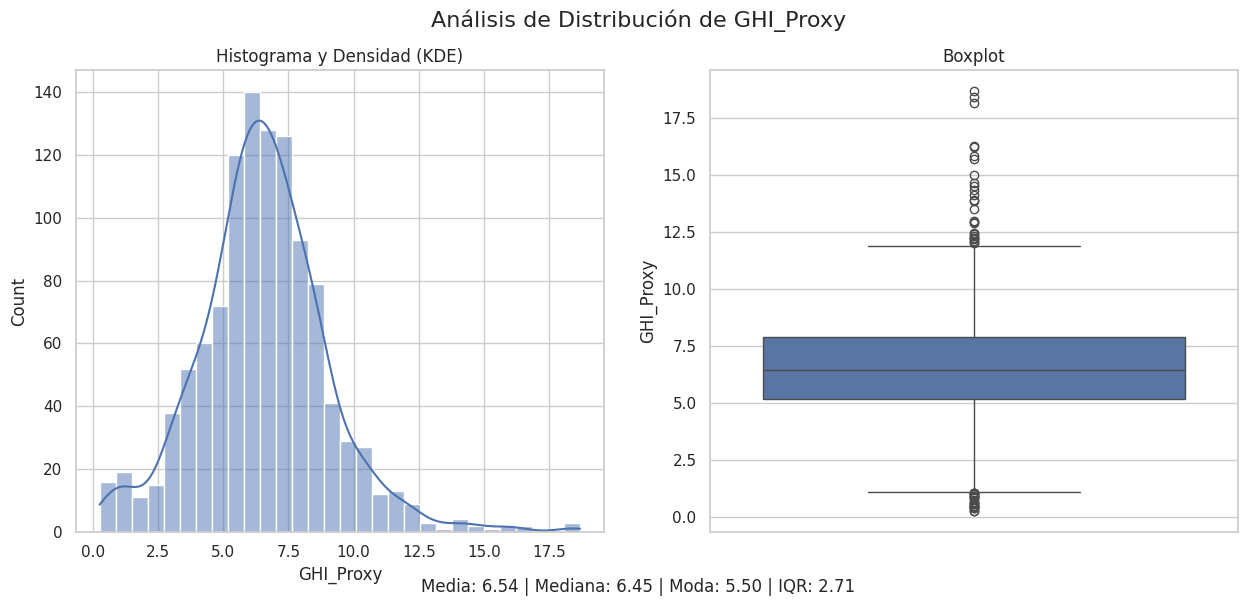



--- 2. An√°lisis Estad√≠stico y Gr√°fico por Mes ---


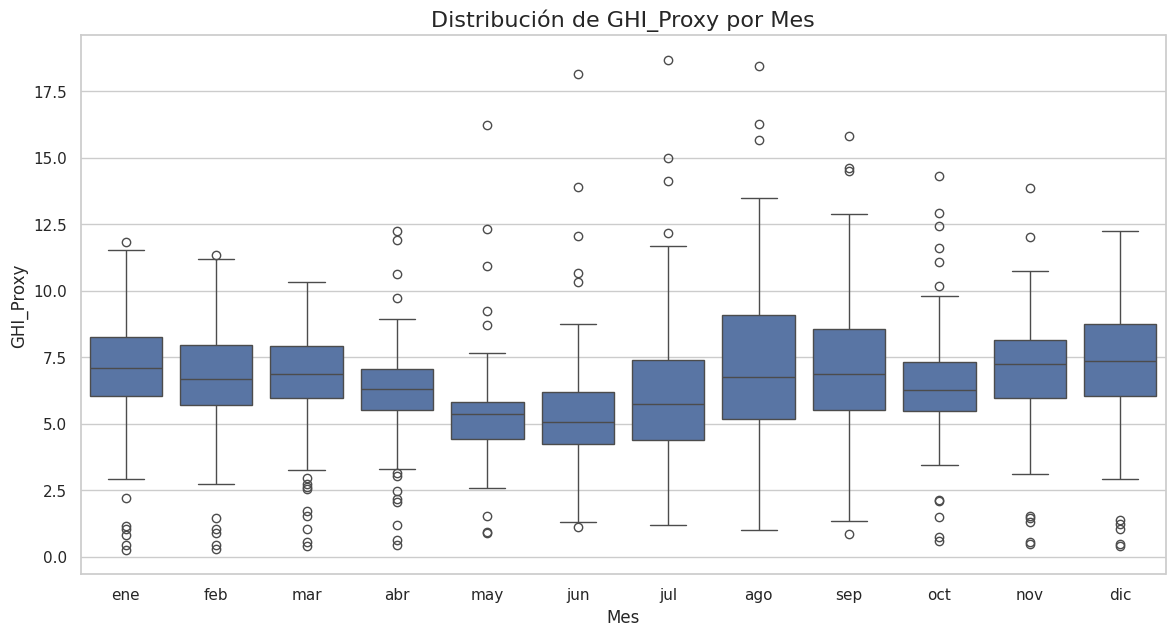



--- 3. An√°lisis Detallado por Regi√≥n Geogr√°fica ---


/tmp/ipykernel_16020/1507471838.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='GHI_Proxy', data=df_wide, order=median_order, palette='plasma')


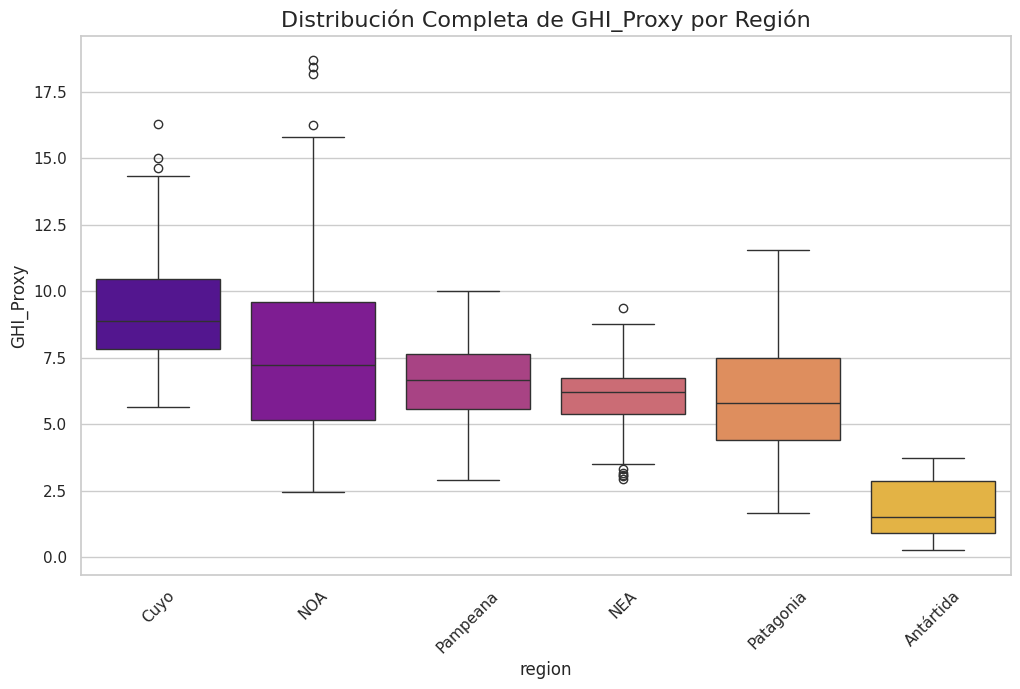



--- 4. Histogramas de GHI_Proxy para Cada Regi√≥n ---


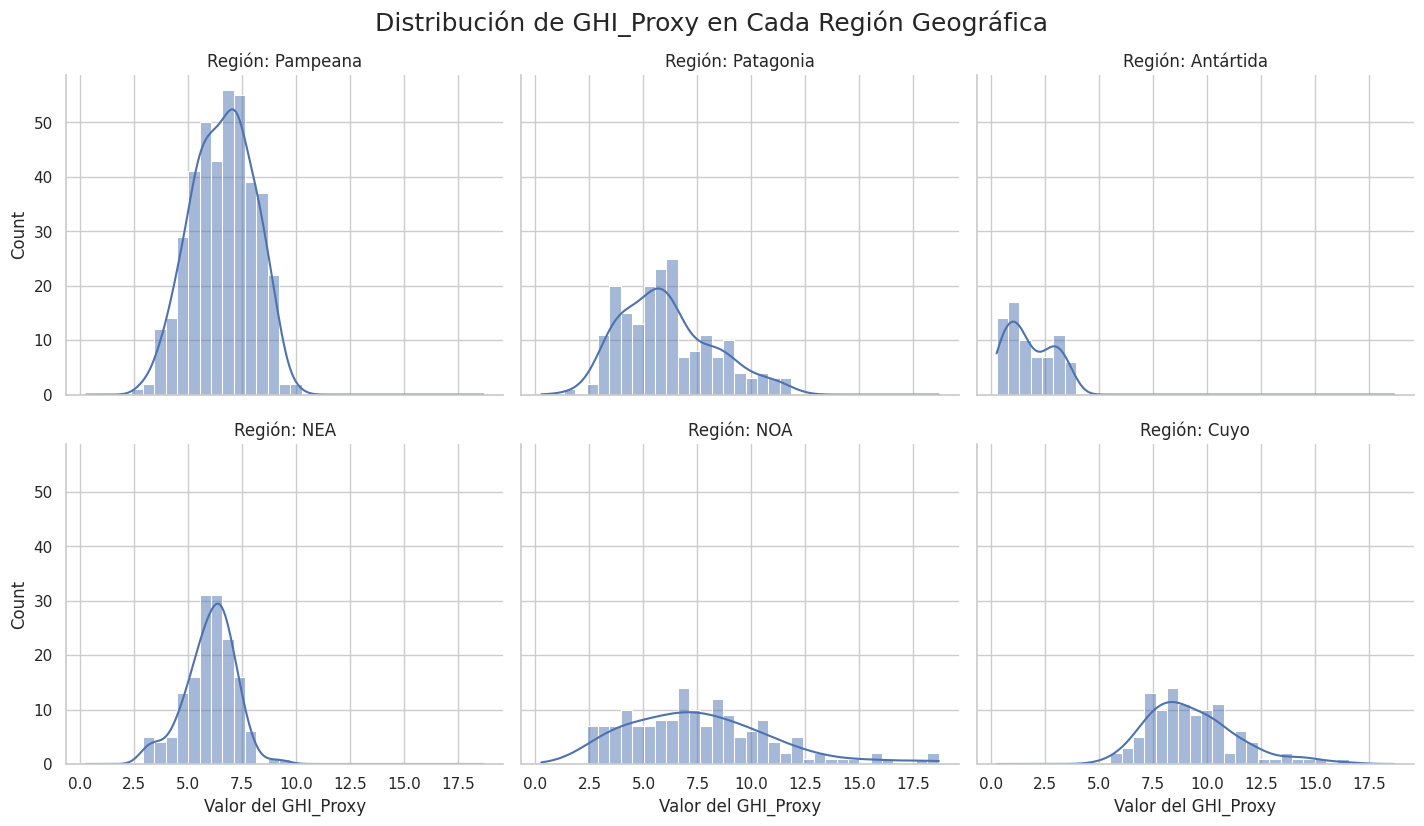

In [69]:
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# --- AN√ÅLISIS 1: VISUALIZACI√ìN DE LA DISTRIBUCI√ìN CON ESTAD√çSTICAS ---
print("--- 1. Distribuci√≥n General de GHI_Proxy ---")

# Calculamos las estad√≠sticas
ghi_mean = df_wide['GHI_Proxy'].mean()
ghi_median = df_wide['GHI_Proxy'].median()
ghi_mode = df_wide['GHI_Proxy'].mode()[0]
ghi_iqr = iqr(df_wide['GHI_Proxy'])

# Creamos la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('An√°lisis de Distribuci√≥n de GHI_Proxy', fontsize=16)

# Histograma y Boxplot
sns.histplot(df_wide['GHI_Proxy'], kde=True, bins=30, ax=ax1)
ax1.set_title('Histograma y Densidad (KDE)')
sns.boxplot(y=df_wide['GHI_Proxy'], ax=ax2)
ax2.set_title('Boxplot')

# A√±adimos el texto con las estad√≠sticas
stats_text = f'Media: {ghi_mean:.2f} | Mediana: {ghi_median:.2f} | Moda: {ghi_mode:.2f} | IQR: {ghi_iqr:.2f}'
fig.text(0.5, 0.01, stats_text, ha='center', fontsize=12)
plt.show()

# --- AN√ÅLISIS 2: COMPORTAMIENTO ESTACIONAL (POR MES) ---
print("\n\n--- 2. An√°lisis Estad√≠stico y Gr√°fico por Mes ---")
meses_ordenados = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
df_wide['Mes'] = df_wide['Mes'].astype(CategoricalDtype(categories=meses_ordenados, ordered=True))

plt.figure(figsize=(14, 7))
sns.boxplot(x='Mes', y='GHI_Proxy', data=df_wide)
plt.title('Distribuci√≥n de GHI_Proxy por Mes', fontsize=16)
plt.show()

# --- AN√ÅLISIS 3: POTENCIAL SOLAR POR REGI√ìN ---
print("\n\n--- 3. An√°lisis Detallado por Regi√≥n Geogr√°fica ---")
median_order = df_wide.groupby('region')['GHI_Proxy'].median().sort_values(ascending=False).index

# Boxplot para ver la distribuci√≥n completa por regi√≥n
plt.figure(figsize=(12, 7))
sns.boxplot(x='region', y='GHI_Proxy', data=df_wide, order=median_order, palette='plasma')
plt.title('Distribuci√≥n Completa de GHI_Proxy por Regi√≥n', fontsize=16)
plt.xticks(rotation=45)
plt.show()

# --- AN√ÅLISIS 4: HISTOGRAMAS POR REGI√ìN ---
print("\n\n--- 4. Histogramas de GHI_Proxy para Cada Regi√≥n ---")

g = sns.displot(
    data=df_wide,
    x="GHI_Proxy",
    col="region",
    col_wrap=3,  
    kde=True,
    height=4,
    aspect=1.2
)
g.fig.suptitle('Distribuci√≥n de GHI_Proxy en Cada Regi√≥n Geogr√°fica', y=1.03, fontsize=18)
g.set_titles("Regi√≥n: {col_name}")
g.set_xlabels("Valor del GHI_Proxy")
plt.show()

Columnas disponibles en el mapa final para GHI_Proxy: Index(['gid', 'entidad', 'fna', 'gna', 'nam', 'in1', 'fdc', 'sag', 'geometry', 'provincia_limpia', 'provincia', 'ghi_media_provincial'], dtype='object')


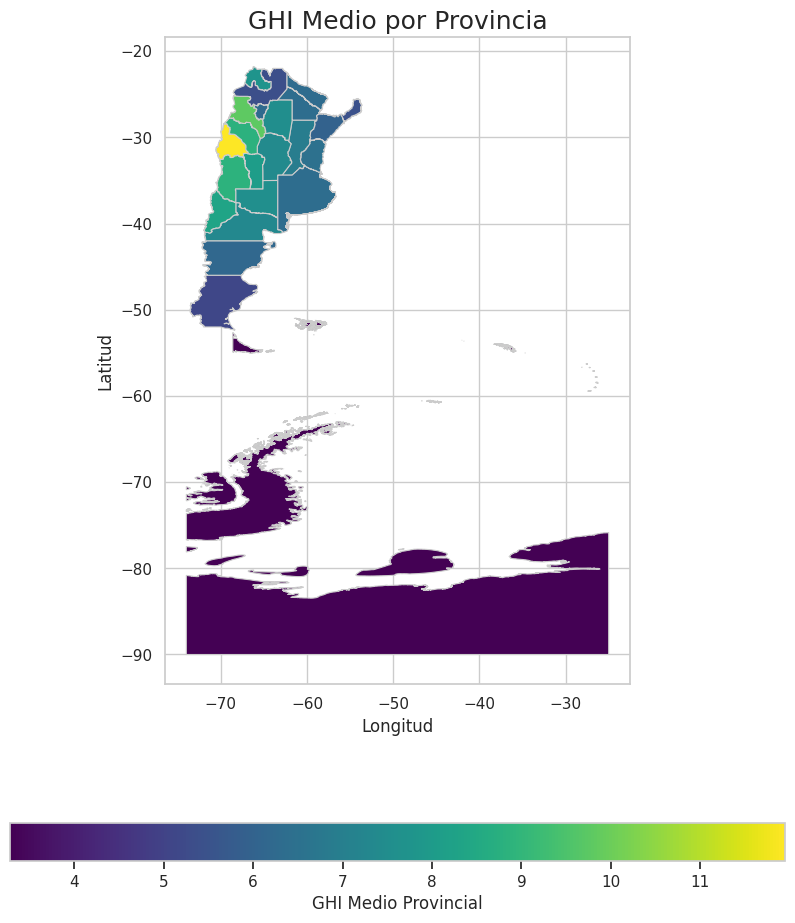

In [73]:
# --- 1. PREPARAR DATOS DE GHI_Proxy POR PROVINCIA ---

# a) Calcular la GHI_Proxy media por provincia
df_ghi_provincia = df_wide.groupby('provincia')['GHI_Proxy'].mean().reset_index()

# b) Renombrar la columna a su nombre final
df_ghi_provincia.rename(columns={'GHI_Proxy': 'ghi_media_provincial'}, inplace=True)

# c) Limpiar los nombres de las provincias para la uni√≥n
df_ghi_provincia['provincia_limpia'] = df_ghi_provincia['provincia'].apply(limpiar_texto)

mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_ghi_provincia['provincia_limpia'] = df_ghi_provincia['provincia_limpia'].replace(mapa_correcciones)

# --- 2. PREPARAR DATOS DEL MAPA ---

ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)

mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)

# --- 3. UNIR LOS DATAFRAMES ---

mapa_final_ghi = pd.merge(
    mapa_provincias,
    df_ghi_provincia,
    on='provincia_limpia',
    how='left'
)

# --- 4. DIBUJAR EL MAPA ---

print("Columnas disponibles en el mapa final para GHI_Proxy:", mapa_final_ghi.columns)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

mapa_final_ghi.plot(
    column='ghi_media_provincial',
    ax=ax,
    legend=True,
    cmap='viridis', # 'viridis' or 'plasma' are good choices for GHI
    linewidth=0.8,
    edgecolor='0.8',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Sin datos",
    },
    
    legend_kwds={'label': "GHI Medio Provincial", 'orientation': "horizontal"}
)

ax.set_title('GHI Medio por Provincia', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

df_wide.drop(columns=['GHI_Proxy'], inplace=True)
df_wide.to_csv('datos/dataset.csv', index=False)


# An√°lisis de la distribuci√≥n de GHI_Proxy

## 1. Distribuci√≥n general de GHI_Proxy

* **Histograma y Densidad (KDE):** La distribuci√≥n de `GHI_Proxy` muestra una forma unimodal, con una cola ligeramente asim√©trica hacia valores altos. La mayor concentraci√≥n de datos se encuentra alrededor de 5-8.
* **Mediana, Moda e IQR:**
    * **Mediana:** 6.54
    * **Moda:** 5.50
    * **Rango Intercuart√≠lico (IQR):** 2.71 
* **Boxplot:** El boxplot confirma la presencia de algunos valores at√≠picos en ambos extremos, particularmente en los valores altos, lo cual es esperable para una medida que busca reflejar la irradiancia solar. La caja principal es relativamente compacta, lo que sugiere que la mayor√≠a de los datos se agrupan alrededor de la mediana.

## 2. Distribuci√≥n de GHI_Proxy por regi√≥n geogr√°fica

* **Pampeana:** Muestra una distribuci√≥n concentrada con una alta frecuencia de valores alrededor de 6-8, lo cual indica un potencial solar consistente en esta regi√≥n.
* **Patagonia:** La distribuci√≥n es m√°s dispersa y bimodal, con picos alrededor de 5 y 10. Esto podr√≠a sugerir variabilidad en las condiciones de nubosidad o la presencia de diferentes patrones clim√°ticos dentro de la regi√≥n.
* **Ant√°rtida:** Presenta valores de `GHI_Proxy` significativamente bajos y una distribuci√≥n estrecha, lo cual es coherente con las condiciones de baja irradiancia solar en esa regi√≥n.
* **NEA (Noreste Argentino):** Similar a la Pampeana, con una concentraci√≥n de valores entre 5 y 8, aunque con una ligera cola hacia valores bajos.
* **NOA (Noroeste Argentino):** Muestra una distribuci√≥n con una moda alta, lo que podr√≠a indicar un mayor potencial solar promedio, aunque tambi√©n presenta una cola hacia valores bajos.
* **Cuyo:** Esta regi√≥n exhibe valores de `GHI_Proxy` consistentemente altos y una distribuci√≥n relativamente estrecha, lo que sugiere un alto potencial solar y menor variabilidad, en l√≠nea con su clima √°rido y mayor cantidad de d√≠as despejados.

## 3. Comparaci√≥n completa de GHI_Proxy por regi√≥n

* **Regiones con mayor potencial solar (mediana alta):**
    * **Cuyo:** Claramente se destaca con la mediana m√°s alta y un rango intercuart√≠lico elevado, lo que confirma su alto potencial solar.
    * **NOA:** Tambi√©n presenta una mediana alta, aunque con mayor dispersi√≥n que Cuyo y presencia de outliers.
* **Regiones con potencial solar moderado:**
    * **Pampeana, NEA, Patagonia:** Estas regiones muestran medianas similares y rangos intercuart√≠licos que se solapan, lo que indica un potencial solar intermedio y con variaciones seg√∫n la regi√≥n.
* **Regi√≥n con menor potencial solar:**
    * **Ant√°rtida:** Confirma los valores muy bajos de `GHI_Proxy`, como se esperaba.
* **Dispersi√≥n y Outliers:** Se observa una mayor dispersi√≥n (cajas grandes) y presencia de outliers en regiones como Cuyo y NOA, lo que sugiere una mayor variabilidad en los d√≠as m√°s o menos soleados.

## 4. Distribuci√≥n de GHI_Proxy por mes


* **Variaci√≥n estacional:** Se observa una clara variaci√≥n estacional en el `GHI_Proxy`. Los meses de **primavera y verano** (octubre, noviembre, diciembre, enero, febrero, marzo) tienden a presentar medianas altas y una mayor dispersi√≥n, lo cual es consistente con una mayor irradiancia solar durante estas estaciones en el hemisferio sur.
* **Meses de invierno:** Los meses de **invierno** (mayo, junio, julio) muestran medianas bajas y, en algunos casos, menor dispersi√≥n, lo que refleja el menor potencial solar debido a la menor altura del sol y, potencialmente, mayor nubosidad.
* **Meses de transici√≥n:** Abril, agosto y septiembre act√∫an como meses de transici√≥n, con medianas que se sit√∫an entre los valores de invierno y verano.
* **Outliers:** La presencia de outliers en todos los meses indica que, incluso en meses con menor potencial general, pueden existir d√≠as con `GHI_Proxy` excepcionalmente altos, y viceversa.

---
# Parte 2: Proceso de transformacion de datos temporales a datos tabulares

Dado el objectivo de transformar el dataset en uno de caracter tabular sin dependecia temporal (serie temporal), se hara la inputacion de datos faltantes haciendo uso de esta naturaleza temporal de los datos iniciales para hacer inputaciones por media estacional. 

In [71]:
corrections_map = {
    'aeroparque_aero': ['CAPITAL FEDERAL', 'GBA', -34.57, -58.42, 6, 87582, 'SABE'],
    'azul_aero': ['BUENOS AIRES', 'PAMPEANA', -36.83, -59.88, 147, 87641, 'SAZA'],
    'bahia_blanca_aero': ['BUENOS AIRES', 'PAMPEANA', -38.72, -62.17, 83, 87750, 'SAZB'],
    'bariloche_aero': ['RIO NEGRO', 'PATAGONICA', -41.15, -71.17, 835, 87765, 'SAZS'],
    'base_belgrano_ii': ['ANTARTIDA', 'ANTARTIDA', -77.87, -34.63, 256, 89034, None],
    'base_carlini_ex_jubany': ['ANTARTIDA', 'ANTARTIDA', -62.23, -58.67, 11, 89053, 'SAYJ'],
    'base_esperanza': ['ANTARTIDA', 'ANTARTIDA', -63.40, -57.00, 24, 89034, 'SAYE'],
    'base_marambio': ['ANTARTIDA', 'ANTARTIDA', -64.23, -56.63, 198, 89033, 'SAWB'],
    'base_orcadas': ['ANTARTIDA', 'ANTARTIDA', -60.73, -44.73, 12, 88963, 'SAYO'],
    'base_san_martin': ['ANTARTIDA', 'ANTARTIDA', -68.13, -67.10, 7, 89066, 'SAYM'],
    'bernardo_de_irigoyen_aero': ['MISIONES', 'NEA', -26.28, -53.67, 815, 87103, 'SATI'],
    'bolivar_aero': ['BUENOS AIRES', 'PAMPEANA', -36.18, -61.07, 94, 87634, 'SAZI'],
    'buenos_aires_observatorio': ['CAPITAL FEDERAL', 'GBA', -34.58, -58.48, 25, 87576, None],
    'catamarca_aero': ['CATAMARCA', 'NOA', -28.60, -65.75, 464, 87217, 'SANC'],
    'ceres_aero': ['SANTA FE', 'PAMPEANA', -29.88, -61.93, 88, 87349, 'SANW'],
    'chamical_aero': ['LA RIOJA', 'NOA', -30.35, -66.30, 461, 87311, 'SACT'],
    'chilecito_aero': ['LA RIOJA', 'NOA', -29.22, -67.45, 947, 87213, 'SANO'],
    'comodoro_rivadavia_aero': ['CHUBUT', 'PATAGONICA', -45.80, -67.47, 46, 87860, 'SAVC'],
    'concordia_aero': ['ENTRE RIOS', 'NEA', -31.30, -58.00, 38, 87480, 'SAAC'],
    'cordoba_aero': ['CORDOBA', 'CENTRO', -31.30, -64.22, 495, 87344, 'SACO'],
    'cordoba_observatorio': ['CORDOBA', 'CENTRO', -31.42, -64.20, 425, 87345, None],
    'coronel_pringles_aero': ['BUENOS AIRES', 'PAMPEANA', -38.00, -61.33, 247, 87751, 'SAZP'],
    'coronel_suarez_aero': ['BUENOS AIRES', 'PAMPEANA', -37.45, -61.88, 233, 87644, 'SAZC'],
    'corrientes_aero': ['CORRIENTES', 'NEA', -27.45, -58.77, 62, 87166, 'SARC'],
    'dolores_aero': ['BUENOS AIRES', 'PAMPEANA', -36.32, -57.72, 9, 87679, 'SAZD'],
    'el_bolson_aero': ['RIO NEGRO', 'PATAGONICA', -41.95, -71.53, 337, 87774, 'SAVB'],
    'el_calafate_aero': ['SANTA CRUZ', 'PATAGONICA', -50.28, -72.08, 204, 87896, 'SAWC'],
    'el_palomar_aero': ['BUENOS AIRES', 'GBA', -34.60, -58.62, 12, 87572, 'SADP'],
    'el_trebol': ['SANTA FE', 'PAMPEANA', -32.20, -61.72, 96, 87447, None],
    'esquel_aero': ['CHUBUT', 'PATAGONICA', -42.90, -71.15, 797, 87803, 'SAVE'],
    'ezeiza_aero': ['BUENOS AIRES', 'GBA', -34.82, -58.55, 20, 87571, 'SAEZ'],
    'formosa_aero': ['FORMOSA', 'NEA', -26.22, -58.22, 60, 87162, 'SARF'],
    'general_pico_aero': ['LA PAMPA', 'PAMPEANA', -35.68, -63.77, 145, 87623, 'SAZG'],
    'gobernador_gregores_aero': ['SANTA CRUZ', 'PATAGONICA', -48.78, -70.17, 358, 87880, 'SAWR'],
    'gualeguaychu_aero': ['ENTRE RIOS', 'NEA', -33.17, -58.62, 23, 87580, 'SAAG'],
    'iguazu_aero': ['MISIONES', 'NEA', -25.73, -54.48, 270, 87097, 'SARI'],
    'jachal': ['SAN JUAN', 'CUYANA', -30.23, -68.73, 1175, 87314, None],
    'jujuy_aero': ['JUJUY', 'NOA', -24.38, -65.10, 907, 87046, 'SASJ'],
    'jujuy_u_n': ['JUJUY', 'NOA', -24.18, -65.33, 1302, 87047, None],
    'junin_aero': ['BUENOS AIRES', 'PAMPEANA', -34.55, -60.93, 81, 87544, 'SAAJ'],
    'la_plata_aero': ['BUENOS AIRES', 'GBA', -34.97, -57.90, 23, 87593, 'SADL'],
    'la_quiaca_observatorio': ['JUJUY', 'NOA', -22.10, -65.60, 3459, 87007, 'SASQ'],
    'la_rioja_aero': ['LA RIOJA', 'NOA', -29.38, -66.80, 429, 87211, 'SANL'],
    'laboulaye_aero': ['CORDOBA', 'CENTRO', -34.13, -63.37, 137, 87534, 'SAOL'],
    'las_flores': ['BUENOS AIRES', 'PAMPEANA', -36.03, -59.13, 36, 87640, None],
    'las_lomitas': ['FORMOSA', 'NEA', -24.70, -60.60, 130, 87078, None],
    'malargue_aero': ['MENDOZA', 'CUYANA', -35.48, -69.58, 1425, 87506, 'SAMM'],
    'maquinchao': ['RIO NEGRO', 'PATAGONICA', -41.25, -68.70, 888, 87770, None],
    'mar_del_plata_aero': ['BUENOS AIRES', 'PAMPEANA', -37.93, -57.58, 21, 87692, 'SAZM'],
    'marcos_juarez_aero': ['CORDOBA', 'CENTRO', -32.68, -62.15, 114, 87448, 'SAOM'],
    'mendoza_aero': ['MENDOZA', 'CUYANA', -32.85, -68.80, 704, 87418, 'SAME'],
    'mendoza_observatorio': ['MENDOZA', 'CUYANA', -32.89, -68.87, 827, 87420, None],
    'monte_caseros_aero': ['CORRIENTES', 'NEA', -30.27, -57.63, 54, 87393, 'SARM'],
    'neuquen_aero': ['NEUQUEN', 'PATAGONICA', -38.95, -68.13, 271, 87715, 'SAZN'],
    'nueve_de_julio': ['BUENOS AIRES', 'PAMPEANA', -35.43, -60.88, 76, 87642, None],
    'obera': ['MISIONES', 'NEA', -27.48, -55.13, 303, 87178, None],
    'olavarria_aero': ['BUENOS AIRES', 'PAMPEANA', -36.88, -60.22, 166, 87645, 'SAZF'],
    'oran_aero': ['SALTA', 'NOA', -23.15, -64.33, 357, 87042, 'SASO'],
    'parana_aero': ['ENTRE RIOS', 'NEA', -31.78, -60.48, 78, 87481, 'SAAP'],
    'paso_de_los_libres_aero': ['CORRIENTES', 'NEA', -29.68, -57.15, 70, 87289, 'SARL'],
    'pehuajo_aero': ['BUENOS AIRES', 'PAMPEANA', -35.83, -61.87, 87, 87632, 'SAZP'],
    'perito_moreno_aero': ['SANTA CRUZ', 'PATAGONICA', -46.53, -70.98, 429, 87834, 'SAWP'],
    'pigue_aero': ['BUENOS AIRES', 'PAMPEANA', -37.60, -62.38, 304, 87752, 'SAZE'],
    'pilar_observatorio': ['CORDOBA', 'CENTRO', -31.67, -63.88, 338, 87347, None],
    'posadas_aero': ['MISIONES', 'NEA', -27.38, -55.97, 125, 87173, 'SARP'],
    'presidencia_roque_saenz_pena_aero': ['CHACO', 'NEA', -26.75, -60.48, 93, 87155, 'SARS'],
    'puerto_deseado_aero': ['SANTA CRUZ', 'PATAGONICA', -47.73, -65.90, 80, 87870, 'SAWD'],
    'punta_indio_ba': ['BUENOS AIRES', 'PAMPEANA', -35.35, -57.30, 22, 87600, 'SAPI'],
    'reconquista_aero': ['SANTA FE', 'PAMPEANA', -29.20, -59.70, 53, 87270, 'SATR'],
    'resistencia_aero': ['CHACO', 'NEA', -27.43, -59.05, 52, 87163, 'SARE'],
    'rio_cuarto_aero': ['CORDOBA', 'CENTRO', -33.10, -64.28, 421, 87444, 'SAOC'],
    'rio_gallegos_aero': ['SANTA CRUZ', 'PATAGONICA', -51.62, -69.30, 19, 87925, 'SAWG'],
    'rio_grande_ba': ['TIERRA DEL FUEGO', 'PATAGONICA', -53.78, -67.77, 22, 87934, 'SAWE'],
    'rosario_aero': ['SANTA FE', 'PAMPEANA', -32.90, -60.78, 25, 87486, 'SAAR'],
    'salta_aero': ['SALTA', 'NOA', -24.85, -65.48, 1221, 87121, 'SASA'],
    'san_antonio_oeste_aero': ['RIO NEGRO', 'PATAGONICA', -40.75, -65.33, 20, 87784, 'SAVN'],
    'san_fernando_aero': ['BUENOS AIRES', 'GBA', -34.45, -58.58, 5, 87580, 'SADF'],
    'san_juan_aero': ['SAN JUAN', 'CUYANA', -31.57, -68.42, 598, 87405, 'SANU'],
    'san_julian_aero': ['SANTA CRUZ', 'PATAGONICA', -49.30, -67.80, 62, 87892, 'SAWJ'],
    'san_luis_aero': ['SAN LUIS', 'CUYANA', -33.27, -66.35, 713, 87528, 'SAOU'],
    'san_martin_mza': ['MENDOZA', 'CUYANA', -33.07, -68.47, 653, 87412, 'SAMI'],
    'san_miguel': ['BUENOS AIRES', 'GBA', -34.54, -58.71, 28, 87570, None],
    'san_rafael_aero': ['MENDOZA', 'CUYANA', -34.58, -68.40, 748, 87503, 'SAMR'],
    'santa_rosa_aero': ['LA PAMPA', 'PAMPEANA', -36.60, -64.28, 191, 87625, 'SAZR'],
    'santiago_del_estero_aero': ['SANTIAGO DEL ESTERO', 'NOA', -27.75, -64.30, 199, 87222, 'SANE'],
    'sauce_viejo_aero': ['SANTA FE', 'PAMPEANA', -31.70, -60.80, 18, 87470, 'SAAV'],
    'tandil_aero': ['BUENOS AIRES', 'PAMPEANA', -37.23, -59.23, 175, 87648, 'SAZT'],
    'tartagal_aero': ['SALTA', 'NOA', -22.62, -63.80, 450, 87034, 'SAST'],
    'tinogasta': ['CATAMARCA', 'NOA', -28.07, -67.57, 1201, 87203, None],
    'trelew_aero': ['CHUBUT', 'PATAGONICA', -43.22, -65.28, 43, 87828, 'SAVT'],
    'tres_arroyos': ['BUENOS AIRES', 'PAMPEANA', -38.37, -60.28, 115, 87754, 'SAZH'],
    'tucuman_aero': ['TUCUMAN', 'NOA', -26.83, -65.12, 450, 87129, 'SANT'],
    'ushuaia_aero': ['TIERRA DEL FUEGO', 'PATAGONICA', -54.83, -68.30, 57, 87938, 'SAWH'],
    'venado_tuerto_aero': ['SANTA FE', 'PAMPEANA', -33.68, -61.97, 112, 87535, 'SAZV'],
    'viedma_aero': ['RIO NEGRO', 'PATAGONICA', -40.87, -63.00, 7, 87791, 'SAVV'],
    'villa_de_maria_del_rio_seco': ['CORDOBA', 'CENTRO', -29.90, -63.73, 341, 87332, None],
    'villa_dolores_aero': ['CORDOBA', 'CENTRO', -31.95, -65.15, 566, 87425, 'SAOD'],
    'villa_reynolds_aero': ['SAN LUIS', 'CUYANA', -33.72, -65.37, 486, 87536, 'SAOR']
}

In [75]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('datos/dataset.csv')
df.rename(columns={'Estaci√≥n': 'estacion', 'Mes': 'mes', 'temperatura_c': 'temperatura'}, inplace=True)

df['mes'] = pd.Categorical(df['mes'], categories=['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic'], ordered=True)
df['mes'] = df['mes'].cat.codes + 1  
df['mes'] = df['mes'].astype(int)

print("-" * 50)
missing_before = df.isnull().sum()
missing_before = missing_before[missing_before > 0]
print("Cantidad de valores faltantes por columna:")
print(missing_before)
print("-" * 50)

COLUMN_TO_DROP = 'velocidad_viento_kmh' 
if COLUMN_TO_DROP in df.columns:
    print(f"Eliminando la columna '{COLUMN_TO_DROP}' por exceso de valores faltantes.")
    df.drop(columns=[COLUMN_TO_DROP], inplace=True)
    
numeric_cols = df.select_dtypes(include=np.number).columns
df_numeric = df[numeric_cols]
df_non_numeric = df.select_dtypes(exclude=np.number)

scaler = StandardScaler()
df_numeric_scaled = scaler.fit_transform(df_numeric)
imputer = KNNImputer(n_neighbors=5)
df_numeric_imputed_scaled = imputer.fit_transform(df_numeric_scaled)
df_numeric_imputed = scaler.inverse_transform(df_numeric_imputed_scaled)
df_numeric_imputed = pd.DataFrame(df_numeric_imputed, columns=numeric_cols)
df_final = pd.concat([df_non_numeric.reset_index(drop=True), df_numeric_imputed.reset_index(drop=True)], axis=1)

print("\n--- AN√ÅLISIS DESPU√âS DE LA IMPUTACI√ìN ---")
missing_after = df_final.isnull().sum().sum()
if missing_after == 0:
    print("‚úÖ ¬°√âxito! Todos los valores faltantes han sido imputados.")
else:
    print(f"ADVERTENCIA: A√∫n quedan {missing_after} valores faltantes.")
print("-" * 50)

mascara_filas_faltantes = df_final.isnull().any(axis=1)
df_con_faltantes = df[mascara_filas_faltantes]
total_filas = len(df_final)
filas_faltantes_count = len(df_con_faltantes)
porcentaje = (filas_faltantes_count / total_filas) * 100

print(f"\nSe encontraron {filas_faltantes_count} filas con datos faltantes (de un total de {total_filas} filas, el {porcentaje:.2f}%).")
print("Estas son las filas espec√≠ficas:")

# Inputacion con data externa, solo aplicar esta en la mascara de filas faltantes, usar de base el corrections_map, actualizar sobre df_final
for index, row in df_con_faltantes.iterrows():
    estacion = row['estacion']
    if estacion in corrections_map:
        provincia, region, latitud, longitud, altura, nro, oaci = corrections_map[estacion]
        df_final.at[index, 'provincia'] = provincia
        df_final.at[index, 'region'] = region
        df_final.at[index, 'latitud'] = latitud
        df_final.at[index, 'longitud'] = longitud
        df_final.at[index, 'altura'] = altura
        df_final.at[index, 'nro'] = nro
        df_final.at[index, 'oaci'] = oaci

missing_after = df_final[df_final['latitud'].isnull()]
    
df_final.to_csv('datos/dataset_cleaned.csv', index=False)




--------------------------------------------------
Cantidad de valores faltantes por columna:
frecuencia_dias_precipitacion_gt_1mm    110
humedad_relativa_porcentaje              61
nubosidad_octavos                         5
precipitacion_mm                        110
temperatura                               4
temperatura_maxima_c                     13
temperatura_minima_c                     47
velocidad_viento_kmh                    463
provincia                                36
region                                   36
latitud                                  36
longitud                                 36
altura                                   36
oaci                                     48
nro                                      36
dtype: int64
--------------------------------------------------
Eliminando la columna 'velocidad_viento_kmh' por exceso de valores faltantes.

--- AN√ÅLISIS DESPU√âS DE LA IMPUTACI√ìN ---
ADVERTENCIA: A√∫n quedan 120 valores faltantes.
----------

In [76]:
variables = [
    'frecuencia_dias_precipitacion_gt_1mm',
    'humedad_relativa_porcentaje',
    'nubosidad_octavos',
    'precipitacion_mm',
    'temperatura',
    'temperatura_maxima_c',
    'temperatura_minima_c',
]

df_agregado = df_final.groupby('estacion')[variables].agg(
    ['mean', 'std', 'max', 'min', 'sum']
)

df_agregado.columns = ['_'.join(col).strip() for col in df_agregado.columns.values]

for var in variables:
    # Rename
    df_agregado.rename(columns={
        f'{var}_mean': f'{var}_anual_media',
        f'{var}_std': f'{var}_anual_std',
        f'{var}_max': f'{var}_anual_max',
        f'{var}_min': f'{var}_anual_min',
        f'{var}_sum': f'{var}_anual_total'
    }, inplace=True)


    mean_col = f'{var}_anual_media'
    std_col = f'{var}_anual_std'
    cv_col = f'{var}_anual_cv'
    df_agregado[cv_col] = np.where(df_agregado[mean_col] != 0, df_agregado[std_col] / df_agregado[mean_col], 0)

    max_col = f'{var}_anual_max'
    min_col = f'{var}_anual_min'
    amplitude_col = f'{var}_anual_amplitud'
    df_agregado[amplitude_col] = df_agregado[max_col] - df_agregado[min_col]
    
info_estaciones = df_final.groupby('estacion').first()[['provincia', 'region', 'oaci', 'latitud', 'longitud', 'altura', 'nro']]

# Reset index of df_agregado to make 'estacion' a column for merging
df_agregado = df_agregado.reset_index()

# Merge info_estaciones with df_agregado
df_tabular = pd.merge(info_estaciones, df_agregado, on='estacion', how='left')

cols_info = ['provincia', 'region', 'oaci', 'latitud', 'longitud', 'altura', 'nro']
cols_features = [col for col in df_tabular.columns if col not in cols_info and col != 'estacion']
df_tabular = df_tabular[['estacion'] + cols_info + sorted(cols_features)]

# Save the new dataframe to a csv file
df_tabular.to_csv('datos/dataset_cleaned_tabular.csv', index=False)



Estad√≠sticas descriptivas:
         latitud   longitud       altura           nro  frecuencia_dias_precipitacion_gt_1mm_anual_amplitud  frecuencia_dias_precipitacion_gt_1mm_anual_cv  frecuencia_dias_precipitacion_gt_1mm_anual_max  frecuencia_dias_precipitacion_gt_1mm_anual_media  frecuencia_dias_precipitacion_gt_1mm_anual_min  frecuencia_dias_precipitacion_gt_1mm_anual_std  frecuencia_dias_precipitacion_gt_1mm_anual_total  humedad_relativa_porcentaje_anual_amplitud  humedad_relativa_porcentaje_anual_cv  humedad_relativa_porcentaje_anual_max  humedad_relativa_porcentaje_anual_media  humedad_relativa_porcentaje_anual_min  humedad_relativa_porcentaje_anual_std  humedad_relativa_porcentaje_anual_total  nubosidad_octavos_anual_amplitud  nubosidad_octavos_anual_cv  nubosidad_octavos_anual_max  nubosidad_octavos_anual_media  nubosidad_octavos_anual_min  nubosidad_octavos_anual_std  nubosidad_octavos_anual_total  precipitacion_mm_anual_amplitud  precipitacion_mm_anual_cv  precipitacion_mm_an

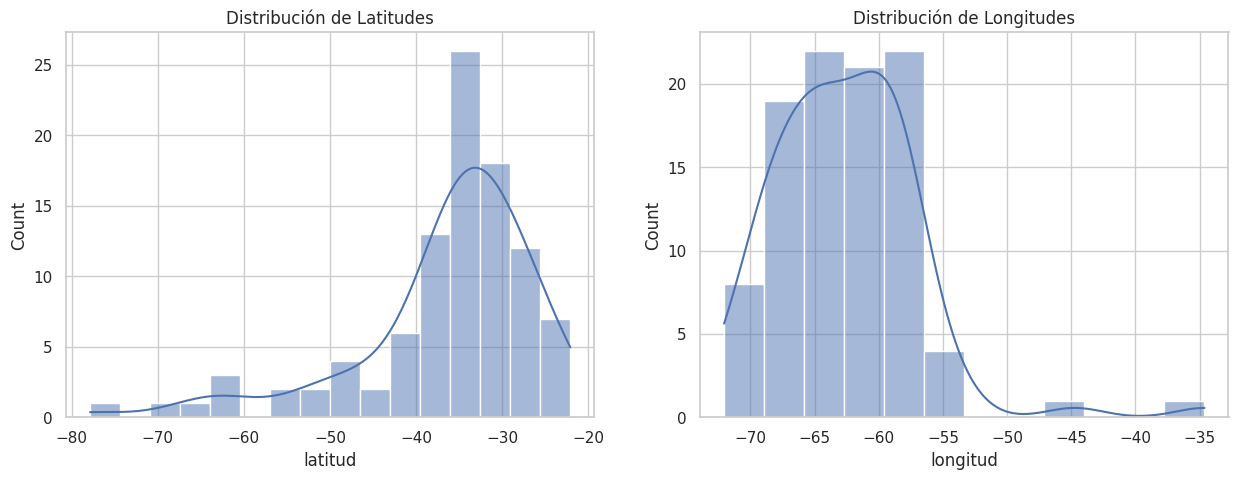

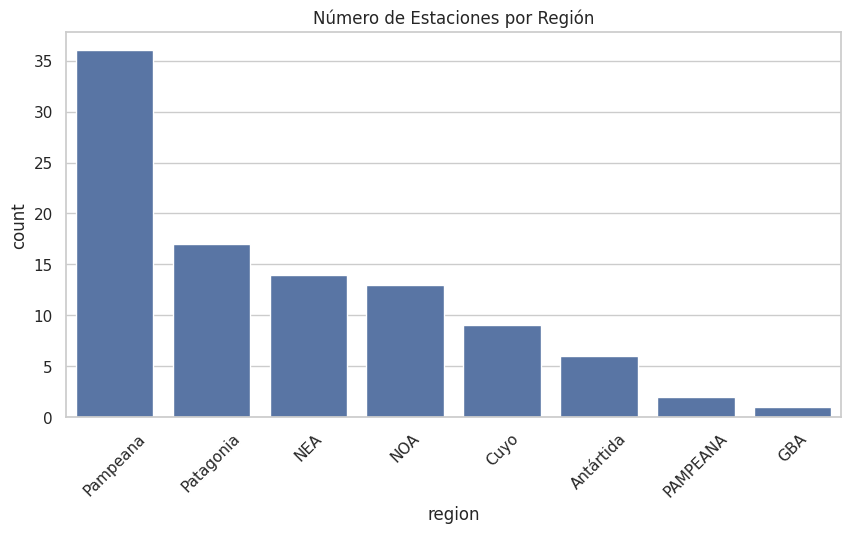

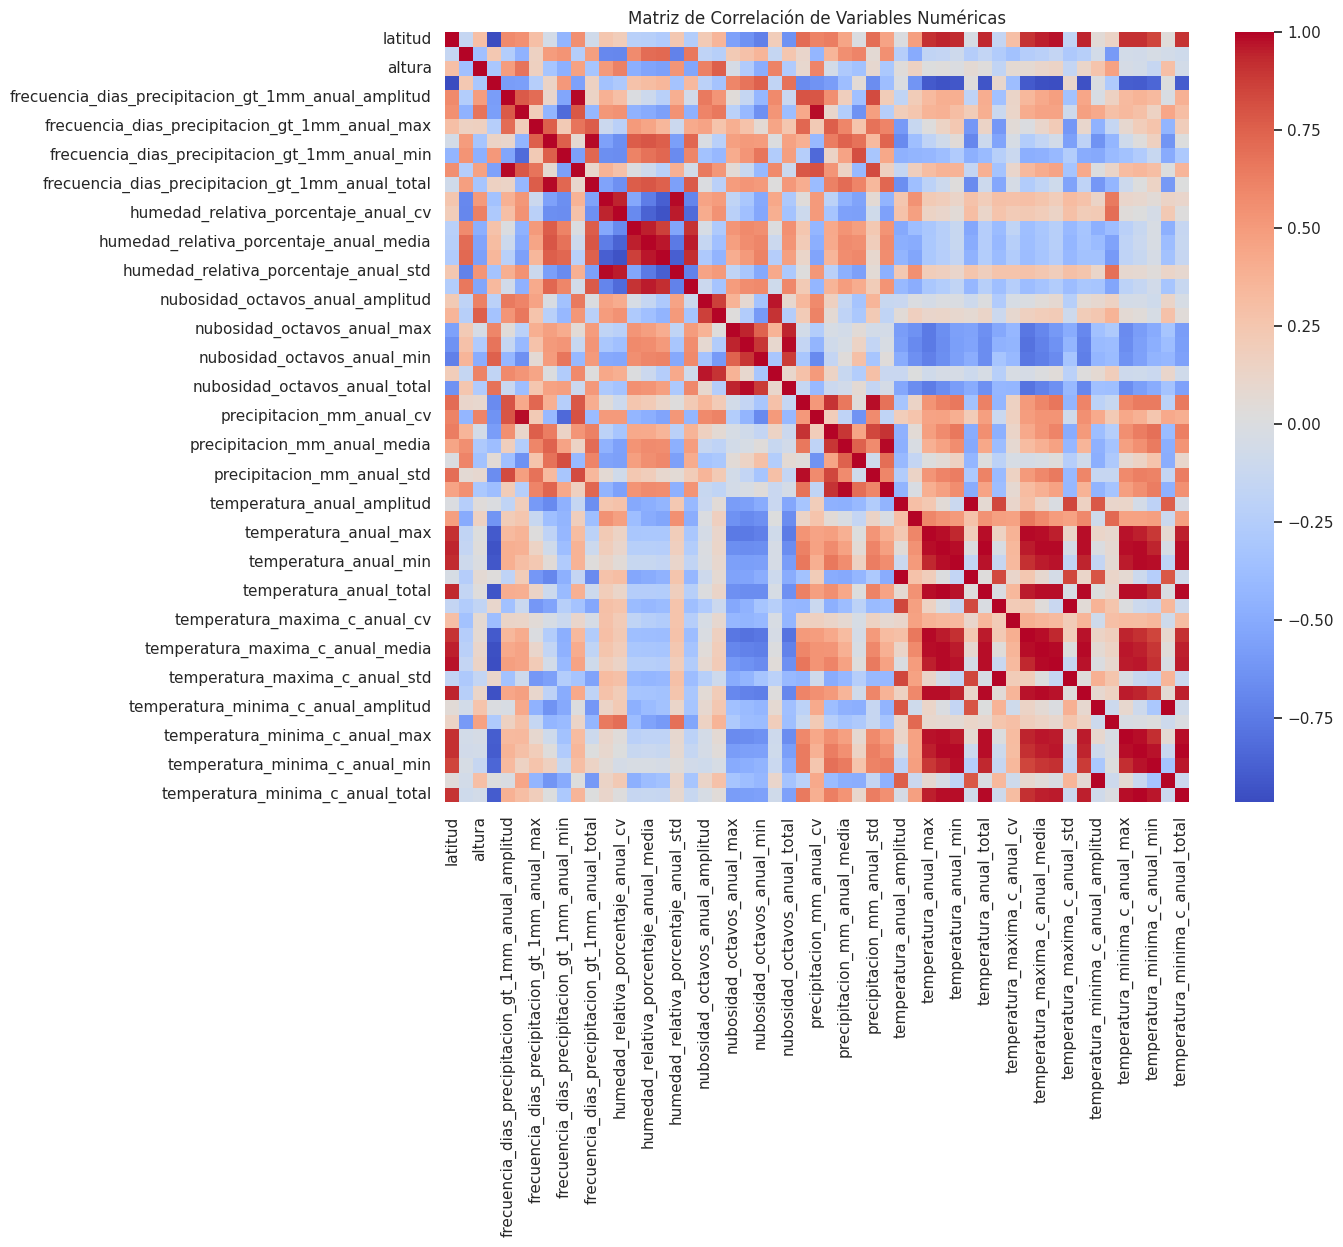

In [77]:
# Summary statistics for numeric columns
print("\nEstad√≠sticas descriptivas:")
print(df_tabular.describe())

# Histograms for a few key variables
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_tabular['latitud'], kde=True)
plt.title('Distribuci√≥n de Latitudes')

plt.subplot(1, 2, 2)
sns.histplot(df_tabular['longitud'], kde=True)
plt.title('Distribuci√≥n de Longitudes')
plt.show()

# Bar plot of station counts by region
plt.figure(figsize=(10, 5))
sns.countplot(data=df_tabular, x='region', order = df_tabular['region'].value_counts().index)
plt.title('N√∫mero de Estaciones por Regi√≥n')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap for numeric features
numeric_columns = df_tabular.select_dtypes(include=['number']).columns
correlation_matrix = df_tabular[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de Correlaci√≥n de Variables Num√©ricas')
plt.show()

---
# Ingenier√≠a de Caracter√≠sticas Astron√≥micas a partir de Coordenadas Geogr√°ficas

In [79]:
df = pd.read_csv('datos/dataset_cleaned_tabular.csv')

# Constante Solar y Radiaci√≥n Extraterrestre
Gs = 1361.0 # W/m¬≤

# - Solsticio de verano del hemisferio sur (dn ‚âà 355, 21 de diciembre)
# - Solsticio de invierno del hemisferio sur (dn ‚âà 172, 21 de junio)

dn_verano = 365
dn_invierno = 172

# Calcular la radiaci√≥n extraterrestre para el solsticio de verano
df['G0_verano_W_m2'] = Gs * (1 + 0.033 * np.cos(2 * np.pi * dn_verano / 365))
# Calcular la radiaci√≥n extraterrestre para el solsticio de invierno
df['G0_invierno_W_m2'] = Gs * (1 + 0.033 * np.cos(2 * np.pi * dn_invierno / 365))


# --- √Ångulo de Declinaci√≥n (Œ¥) ---
delta_verano_rad = np.deg2rad(23.45 * np.sin(2 * np.pi * (dn_verano + 284) / 365))
delta_invierno_rad = np.deg2rad(23.45 * np.sin(2 * np.pi * (dn_invierno + 284) / 365))


df['declinacion_verano_grados'] = np.rad2deg(delta_verano_rad)
df['declinacion_invierno_grados'] = np.rad2deg(delta_invierno_rad)

latitud_rad = np.deg2rad(df['latitud'])

# Ecuaci√≥n para el √°ngulo horario de la puesta de Sol (œâs)
cos_omega_s_verano = -np.tan(delta_verano_rad) * np.tan(latitud_rad)
cos_omega_s_invierno = -np.tan(delta_invierno_rad) * np.tan(latitud_rad)

omega_s_verano_rad = np.arccos(np.clip(cos_omega_s_verano, -1.0, 1.0))
omega_s_invierno_rad = np.arccos(np.clip(cos_omega_s_invierno, -1.0, 1.0))

omega_s_verano_deg = np.rad2deg(omega_s_verano_rad)
omega_s_invierno_deg = np.rad2deg(omega_s_invierno_rad)

df['duracion_dia_verano_horas'] = 2 * omega_s_verano_deg / 15
df['duracion_dia_invierno_horas'] = 2 * omega_s_invierno_deg / 15


# --- √Ångulo Cenital Solar (Œ∏zs) al mediod√≠a solar ---
# Al mediod√≠a solar, el √°ngulo horario (œâ) es 0, por lo que cos(œâ) = 1.
# La ecuaci√≥n se simplifica a: cos(Œ∏zs) = cos(Œ¥)cos(œï) + sin(Œ¥)sin(œï) = cos(œï - Œ¥)
# Por lo tanto, Œ∏zs = |œï - Œ¥|

df['angulo_cenital_mediodia_verano_grados'] = np.abs(df['latitud'] - np.rad2deg(delta_verano_rad))
df['angulo_cenital_mediodia_invierno_grados'] = np.abs(df['latitud'] - np.rad2deg(delta_invierno_rad))

output_filename = 'datos/dataset_cleaned_tabular_engineered.csv'
df.to_csv(output_filename, index=False, float_format='%.4f')



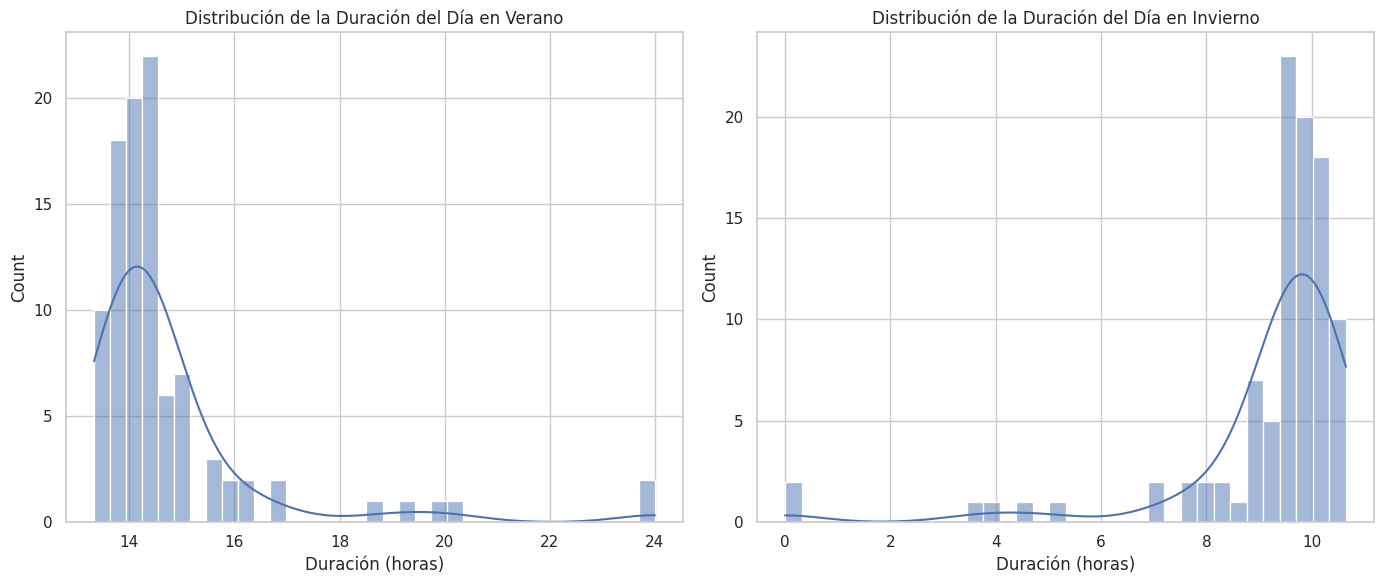

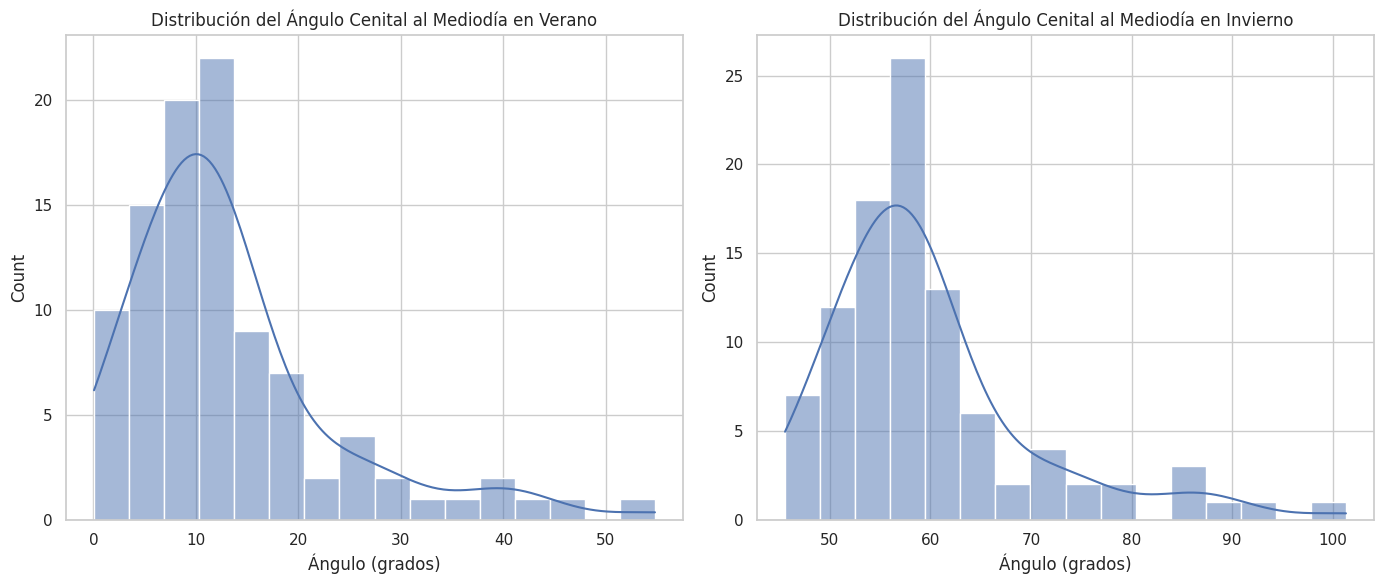

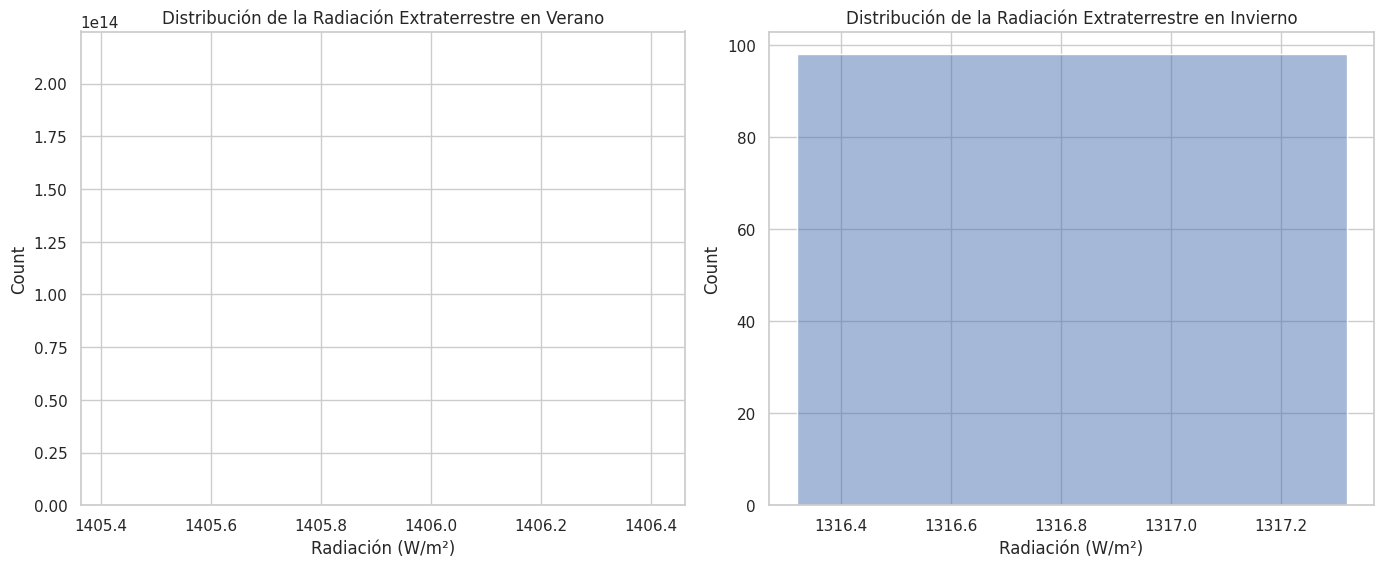

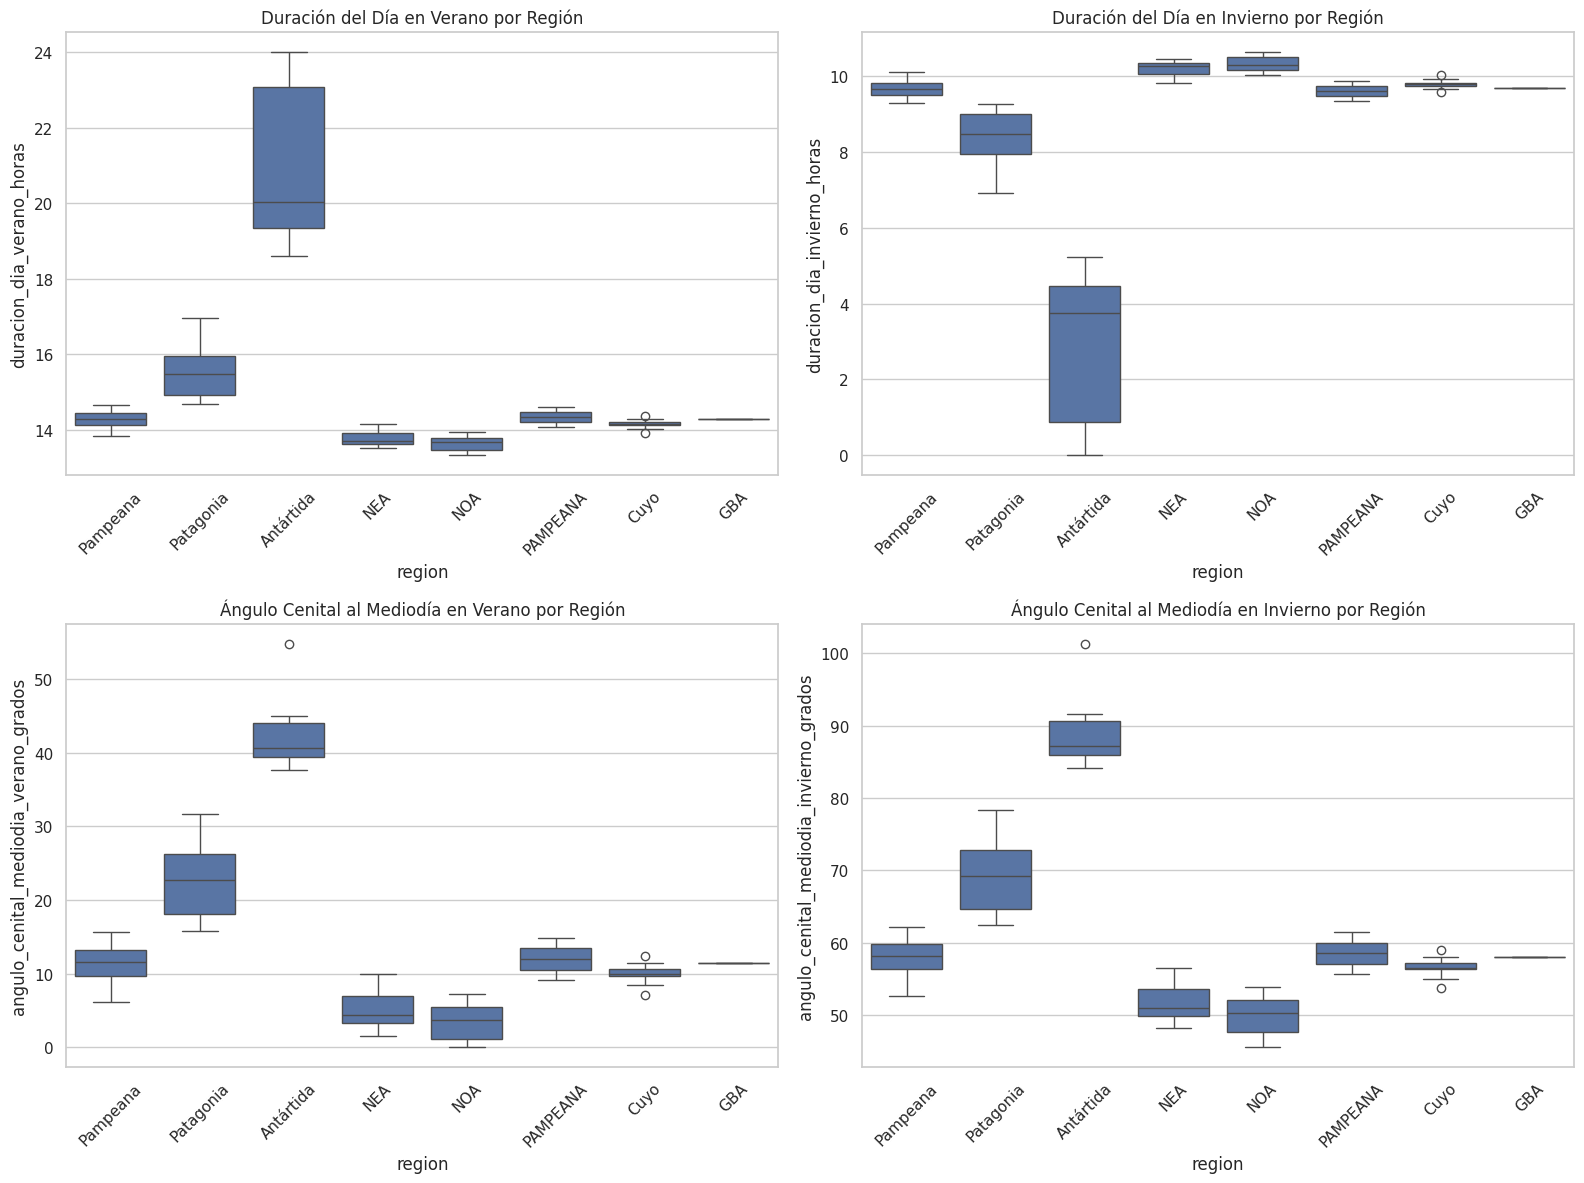

In [80]:
df = pd.read_csv('datos/dataset_cleaned_tabular_engineered.csv')

# Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt

# Configuraci√≥n general de los gr√°ficos
sns.set_theme(style="whitegrid")

# 1. Distribuci√≥n de la Duraci√≥n del D√≠a en Verano e Invierno
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['duracion_dia_verano_horas'], kde=True)
plt.title('Distribuci√≥n de la Duraci√≥n del D√≠a en Verano')
plt.xlabel('Duraci√≥n (horas)')

plt.subplot(1, 2, 2)
sns.histplot(df['duracion_dia_invierno_horas'], kde=True)
plt.title('Distribuci√≥n de la Duraci√≥n del D√≠a en Invierno')
plt.xlabel('Duraci√≥n (horas)')

plt.tight_layout()
plt.show()

# 2. Distribuci√≥n del √Ångulo Cenital al Mediod√≠a en Verano e Invierno
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['angulo_cenital_mediodia_verano_grados'], kde=True)
plt.title('Distribuci√≥n del √Ångulo Cenital al Mediod√≠a en Verano')
plt.xlabel('√Ångulo (grados)')

plt.subplot(1, 2, 2)
sns.histplot(df['angulo_cenital_mediodia_invierno_grados'], kde=True)
plt.title('Distribuci√≥n del √Ångulo Cenital al Mediod√≠a en Invierno')
plt.xlabel('√Ångulo (grados)')

plt.tight_layout()
plt.show()

# 3. Radiaci√≥n Extraterrestre en Verano e Invierno
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['G0_verano_W_m2'], kde=True)
plt.title('Distribuci√≥n de la Radiaci√≥n Extraterrestre en Verano')
plt.xlabel('Radiaci√≥n (W/m¬≤)')

plt.subplot(1, 2, 2)
sns.histplot(df['G0_invierno_W_m2'], kde=True)
plt.title('Distribuci√≥n de la Radiaci√≥n Extraterrestre en Invierno')
plt.xlabel('Radiaci√≥n (W/m¬≤)')

plt.tight_layout()
plt.show()

# 4. Boxplots comparando las variables astron√≥micas por regi√≥n
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.boxplot(ax=axes[0, 0], x='region', y='duracion_dia_verano_horas', data=df)
axes[0, 0].set_title('Duraci√≥n del D√≠a en Verano por Regi√≥n')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[0, 1], x='region', y='duracion_dia_invierno_horas', data=df)
axes[0, 1].set_title('Duraci√≥n del D√≠a en Invierno por Regi√≥n')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[1, 0], x='region', y='angulo_cenital_mediodia_verano_grados', data=df)
axes[1, 0].set_title('√Ångulo Cenital al Mediod√≠a en Verano por Regi√≥n')
axes[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[1, 1], x='region', y='angulo_cenital_mediodia_invierno_grados', data=df)
axes[1, 1].set_title('√Ångulo Cenital al Mediod√≠a en Invierno por Regi√≥n')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()